In [263]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [264]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [265]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [266]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 3289
Total Drives: 84218
Total Plays: 595530


In [267]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 83699


In [268]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [269]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [270]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO']


def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'HavocRate': [havoc]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def map_to_base_value(base, inpt, multiplier):
    return multiplier * (inpt / base)

def modifier_sum():
    return sum([0.6,0.3,0.1, 0.47, 0.3, 0.4, 0.45, 0.3, 0.5, 0.2])

def calculate_five_factors_rating(team_stat_pack):
    return sum([(map_to_base_value(modifier_sum(),0.6,1) * team_stat_pack.OffSRDiff),(map_to_base_value(modifier_sum(),0.3,1) * team_stat_pack.OffERDiff),(map_to_base_value(modifier_sum(),0.1,1) * team_stat_pack.FPDiff),(map_to_base_value(modifier_sum(),0.47,1) * team_stat_pack.OppRateDiff),(map_to_base_value(modifier_sum(),0.3,1) * team_stat_pack.OppEffDiff),(map_to_base_value(modifier_sum(),0.45,1) * team_stat_pack.PPDDiff),(map_to_base_value(modifier_sum(),0.3,1) * team_stat_pack.OppSRDiff),(map_to_base_value(modifier_sum(),0.5,1) * team_stat_pack.YPPDiff),-(map_to_base_value(modifier_sum(),0.2,1) * team_stat_pack.ExpTODiff)])

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if (year == 2016):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,...,-5.4,-0.104762,0.208333,1.791667,-0.052381,0.118588,0.994779,-0.66,0.039046,0.078093
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,...,5.4,0.104762,-0.208333,-1.791667,0.052381,-0.118588,-0.994779,0.66,-0.039046,-0.078093


In [271]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/3289] Getting game information for ESPN game_id: 400869090
[1/3289] Started processing game information for ESPN game_id: 400869090
[1/3289] Completed processing game information for ESPN game_id: 400869090
[1/3289] Aggreggating game_id 400869090 to master data copy
[2/3289] Getting game information for ESPN game_id: 400869421
[2/3289] Started processing game information for ESPN game_id: 400869421
[2/3289] Completed processing game information for ESPN game_id: 400869421
[2/3289] Aggreggating game_id 400869421 to master data copy
[3/3289] Getting game information for ESPN game_id: 400869257
[3/3289] Started processing game information for ESPN game_id: 400869257
[3/3289] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[4/3289] Getting game information for ESPN game_id: 400869502
[4/3289] Started processing game information for ESPN game_id: 400869502
[4/3289] Skipping checking game_id 400869502 bc one of the teams isn't FBS
[5/3289] Getting game information for ES

[35/3289] Completed processing game information for ESPN game_id: 400868976
[35/3289] Aggreggating game_id 400868976 to master data copy
[36/3289] Getting game information for ESPN game_id: 400869507
[36/3289] Started processing game information for ESPN game_id: 400869507
[36/3289] Completed processing game information for ESPN game_id: 400869507
[36/3289] Aggreggating game_id 400869507 to master data copy
[37/3289] Getting game information for ESPN game_id: 400869260
[37/3289] Started processing game information for ESPN game_id: 400869260
[37/3289] Completed processing game information for ESPN game_id: 400869260
[37/3289] Aggreggating game_id 400869260 to master data copy
[38/3289] Getting game information for ESPN game_id: 400869509
[38/3289] Started processing game information for ESPN game_id: 400869509
[38/3289] Skipping checking game_id 400869509 bc one of the teams isn't FBS
[39/3289] Getting game information for ESPN game_id: 400869267
[39/3289] Started processing game infor

[72/3289] Completed processing game information for ESPN game_id: 400868957
[72/3289] Aggreggating game_id 400868957 to master data copy
[73/3289] Getting game information for ESPN game_id: 400869624
[73/3289] Started processing game information for ESPN game_id: 400869624
[73/3289] Skipping checking game_id 400869624 bc one of the teams isn't FBS
[74/3289] Getting game information for ESPN game_id: 400868969
[74/3289] Started processing game information for ESPN game_id: 400868969
[74/3289] Completed processing game information for ESPN game_id: 400868969
[74/3289] Aggreggating game_id 400868969 to master data copy
[75/3289] Getting game information for ESPN game_id: 400868887
[75/3289] Started processing game information for ESPN game_id: 400868887
[75/3289] Skipping checking game_id 400868887 bc one of the teams isn't FBS
[76/3289] Getting game information for ESPN game_id: 400869179
[76/3289] Started processing game information for ESPN game_id: 400869179
[76/3289] Completed proces

[108/3289] Completed processing game information for ESPN game_id: 400869101
[108/3289] Aggreggating game_id 400869101 to master data copy
[109/3289] Getting game information for ESPN game_id: 400869277
[109/3289] Started processing game information for ESPN game_id: 400869277
[109/3289] Completed processing game information for ESPN game_id: 400869277
[109/3289] Aggreggating game_id 400869277 to master data copy
[110/3289] Getting game information for ESPN game_id: 400869433
[110/3289] Started processing game information for ESPN game_id: 400869433
[110/3289] Skipping checking game_id 400869433 bc one of the teams isn't FBS
[111/3289] Getting game information for ESPN game_id: 400868877
[111/3289] Started processing game information for ESPN game_id: 400868877
[111/3289] Completed processing game information for ESPN game_id: 400868877
[111/3289] Aggreggating game_id 400868877 to master data copy
[112/3289] Getting game information for ESPN game_id: 400868980
[112/3289] Started proces

[143/3289] Completed processing game information for ESPN game_id: 400869612
[143/3289] Aggreggating game_id 400869612 to master data copy
[144/3289] Getting game information for ESPN game_id: 400868981
[144/3289] Started processing game information for ESPN game_id: 400868981
[144/3289] Completed processing game information for ESPN game_id: 400868981
[144/3289] Aggreggating game_id 400868981 to master data copy
[145/3289] Getting game information for ESPN game_id: 400869357
[145/3289] Started processing game information for ESPN game_id: 400869357
[145/3289] Completed processing game information for ESPN game_id: 400869357
[145/3289] Aggreggating game_id 400869357 to master data copy
[146/3289] Getting game information for ESPN game_id: 400868888
[146/3289] Started processing game information for ESPN game_id: 400868888
[146/3289] Completed processing game information for ESPN game_id: 400868888
[146/3289] Aggreggating game_id 400868888 to master data copy
[147/3289] Getting game inf

[176/3289] Completed processing game information for ESPN game_id: 400869281
[176/3289] Aggreggating game_id 400869281 to master data copy
[177/3289] Getting game information for ESPN game_id: 400869519
[177/3289] Started processing game information for ESPN game_id: 400869519
[177/3289] Completed processing game information for ESPN game_id: 400869519
[177/3289] Aggreggating game_id 400869519 to master data copy
[178/3289] Getting game information for ESPN game_id: 400869520
[178/3289] Started processing game information for ESPN game_id: 400869520
[178/3289] Completed processing game information for ESPN game_id: 400869520
[178/3289] Aggreggating game_id 400869520 to master data copy
[179/3289] Getting game information for ESPN game_id: 400869001
[179/3289] Started processing game information for ESPN game_id: 400869001
[179/3289] Completed processing game information for ESPN game_id: 400869001
[179/3289] Aggreggating game_id 400869001 to master data copy
[180/3289] Getting game inf

[209/3289] Completed processing game information for ESPN game_id: 400868993
[209/3289] Aggreggating game_id 400868993 to master data copy
[210/3289] Getting game information for ESPN game_id: 400868996
[210/3289] Started processing game information for ESPN game_id: 400868996
[210/3289] Completed processing game information for ESPN game_id: 400868996
[210/3289] Aggreggating game_id 400868996 to master data copy
[211/3289] Getting game information for ESPN game_id: 400869521
[211/3289] Started processing game information for ESPN game_id: 400869521
[211/3289] Completed processing game information for ESPN game_id: 400869521
[211/3289] Aggreggating game_id 400869521 to master data copy
[212/3289] Getting game information for ESPN game_id: 400869522
[212/3289] Started processing game information for ESPN game_id: 400869522
[212/3289] Completed processing game information for ESPN game_id: 400869522
[212/3289] Aggreggating game_id 400869522 to master data copy
[213/3289] Getting game inf

[240/3289] Completed processing game information for ESPN game_id: 400869363
[240/3289] Aggreggating game_id 400869363 to master data copy
[241/3289] Getting game information for ESPN game_id: 400869204
[241/3289] Started processing game information for ESPN game_id: 400869204
[241/3289] Completed processing game information for ESPN game_id: 400869204
[241/3289] Aggreggating game_id 400869204 to master data copy
[242/3289] Getting game information for ESPN game_id: 400869203
[242/3289] Started processing game information for ESPN game_id: 400869203
[242/3289] Completed processing game information for ESPN game_id: 400869203
[242/3289] Aggreggating game_id 400869203 to master data copy
[243/3289] Getting game information for ESPN game_id: 400869288
[243/3289] Started processing game information for ESPN game_id: 400869288
[243/3289] Completed processing game information for ESPN game_id: 400869288
[243/3289] Aggreggating game_id 400869288 to master data copy
[244/3289] Getting game inf

[271/3289] Completed processing game information for ESPN game_id: 400869816
[271/3289] Aggreggating game_id 400869816 to master data copy
[272/3289] Getting game information for ESPN game_id: 400869365
[272/3289] Started processing game information for ESPN game_id: 400869365
[272/3289] Completed processing game information for ESPN game_id: 400869365
[272/3289] Aggreggating game_id 400869365 to master data copy
[273/3289] Getting game information for ESPN game_id: 400868913
[273/3289] Started processing game information for ESPN game_id: 400868913
[273/3289] Completed processing game information for ESPN game_id: 400868913
[273/3289] Aggreggating game_id 400868913 to master data copy
[274/3289] Getting game information for ESPN game_id: 400869815
[274/3289] Started processing game information for ESPN game_id: 400869815
[274/3289] Skipping checking game_id 400869815 bc one of the teams isn't FBS
[275/3289] Getting game information for ESPN game_id: 400869605
[275/3289] Started proces

[303/3289] Completed processing game information for ESPN game_id: 400869620
[303/3289] Aggreggating game_id 400869620 to master data copy
[304/3289] Getting game information for ESPN game_id: 400869454
[304/3289] Started processing game information for ESPN game_id: 400869454
[304/3289] Completed processing game information for ESPN game_id: 400869454
[304/3289] Aggreggating game_id 400869454 to master data copy
[305/3289] Getting game information for ESPN game_id: 400869294
[305/3289] Started processing game information for ESPN game_id: 400869294
[305/3289] Completed processing game information for ESPN game_id: 400869294
[305/3289] Aggreggating game_id 400869294 to master data copy
[306/3289] Getting game information for ESPN game_id: 400869296
[306/3289] Started processing game information for ESPN game_id: 400869296
[306/3289] Completed processing game information for ESPN game_id: 400869296
[306/3289] Aggreggating game_id 400869296 to master data copy
[307/3289] Getting game inf

[334/3289] Completed processing game information for ESPN game_id: 400869371
[334/3289] Aggreggating game_id 400869371 to master data copy
[335/3289] Getting game information for ESPN game_id: 400869010
[335/3289] Started processing game information for ESPN game_id: 400869010
[335/3289] Completed processing game information for ESPN game_id: 400869010
[335/3289] Aggreggating game_id 400869010 to master data copy
[336/3289] Getting game information for ESPN game_id: 400869374
[336/3289] Started processing game information for ESPN game_id: 400869374
[336/3289] Completed processing game information for ESPN game_id: 400869374
[336/3289] Aggreggating game_id 400869374 to master data copy
[337/3289] Getting game information for ESPN game_id: 400869014
[337/3289] Started processing game information for ESPN game_id: 400869014
[337/3289] Completed processing game information for ESPN game_id: 400869014
[337/3289] Aggreggating game_id 400869014 to master data copy
[338/3289] Getting game inf

[365/3289] Completed processing game information for ESPN game_id: 400869021
[365/3289] Aggreggating game_id 400869021 to master data copy
[366/3289] Getting game information for ESPN game_id: 400868951
[366/3289] Started processing game information for ESPN game_id: 400868951
[366/3289] Completed processing game information for ESPN game_id: 400868951
[366/3289] Aggreggating game_id 400868951 to master data copy
[367/3289] Getting game information for ESPN game_id: 400869458
[367/3289] Started processing game information for ESPN game_id: 400869458
[367/3289] Completed processing game information for ESPN game_id: 400869458
[367/3289] Aggreggating game_id 400869458 to master data copy
[368/3289] Getting game information for ESPN game_id: 400869300
[368/3289] Started processing game information for ESPN game_id: 400869300
[368/3289] Completed processing game information for ESPN game_id: 400869300
[368/3289] Aggreggating game_id 400869300 to master data copy
[369/3289] Getting game inf

[395/3289] Completed processing game information for ESPN game_id: 400869378
[395/3289] Aggreggating game_id 400869378 to master data copy
[396/3289] Getting game information for ESPN game_id: 400869722
[396/3289] Started processing game information for ESPN game_id: 400869722
[396/3289] Completed processing game information for ESPN game_id: 400869722
[396/3289] Aggreggating game_id 400869722 to master data copy
[397/3289] Getting game information for ESPN game_id: 400869134
[397/3289] Started processing game information for ESPN game_id: 400869134
[397/3289] Completed processing game information for ESPN game_id: 400869134
[397/3289] Aggreggating game_id 400869134 to master data copy
[398/3289] Getting game information for ESPN game_id: 400869130
[398/3289] Started processing game information for ESPN game_id: 400869130
[398/3289] Completed processing game information for ESPN game_id: 400869130
[398/3289] Aggreggating game_id 400869130 to master data copy
[399/3289] Getting game inf

[426/3289] Completed processing game information for ESPN game_id: 400869136
[426/3289] Aggreggating game_id 400869136 to master data copy
[427/3289] Getting game information for ESPN game_id: 400869219
[427/3289] Started processing game information for ESPN game_id: 400869219
[427/3289] Completed processing game information for ESPN game_id: 400869219
[427/3289] Aggreggating game_id 400869219 to master data copy
[428/3289] Getting game information for ESPN game_id: 400869672
[428/3289] Started processing game information for ESPN game_id: 400869672
[428/3289] Completed processing game information for ESPN game_id: 400869672
[428/3289] Aggreggating game_id 400869672 to master data copy
[429/3289] Getting game information for ESPN game_id: 400869827
[429/3289] Started processing game information for ESPN game_id: 400869827
[429/3289] Completed processing game information for ESPN game_id: 400869827
[429/3289] Aggreggating game_id 400869827 to master data copy
[430/3289] Getting game inf

[455/3289] Completed processing game information for ESPN game_id: 400869220
[455/3289] Aggreggating game_id 400869220 to master data copy
[456/3289] Getting game information for ESPN game_id: 400869138
[456/3289] Started processing game information for ESPN game_id: 400869138
[456/3289] Completed processing game information for ESPN game_id: 400869138
[456/3289] Aggreggating game_id 400869138 to master data copy
[457/3289] Getting game information for ESPN game_id: 400869223
[457/3289] Started processing game information for ESPN game_id: 400869223
[457/3289] Completed processing game information for ESPN game_id: 400869223
[457/3289] Aggreggating game_id 400869223 to master data copy
[458/3289] Getting game information for ESPN game_id: 400869222
[458/3289] Started processing game information for ESPN game_id: 400869222
[458/3289] Completed processing game information for ESPN game_id: 400869222
[458/3289] Aggreggating game_id 400869222 to master data copy
[459/3289] Getting game inf

[486/3289] Completed processing game information for ESPN game_id: 400869628
[486/3289] Aggreggating game_id 400869628 to master data copy
[487/3289] Getting game information for ESPN game_id: 400869314
[487/3289] Started processing game information for ESPN game_id: 400869314
[487/3289] Completed processing game information for ESPN game_id: 400869314
[487/3289] Aggreggating game_id 400869314 to master data copy
[488/3289] Getting game information for ESPN game_id: 400869546
[488/3289] Started processing game information for ESPN game_id: 400869546
[488/3289] Completed processing game information for ESPN game_id: 400869546
[488/3289] Aggreggating game_id 400869546 to master data copy
[489/3289] Getting game information for ESPN game_id: 400869831
[489/3289] Started processing game information for ESPN game_id: 400869831
[489/3289] Skipping checking game_id 400869831 bc one of the teams isn't FBS
[490/3289] Getting game information for ESPN game_id: 400869833
[490/3289] Started proces

[517/3289] Completed processing game information for ESPN game_id: 400869318
[517/3289] Aggreggating game_id 400869318 to master data copy
[518/3289] Getting game information for ESPN game_id: 400869317
[518/3289] Started processing game information for ESPN game_id: 400869317
[518/3289] Completed processing game information for ESPN game_id: 400869317
[518/3289] Aggreggating game_id 400869317 to master data copy
[519/3289] Getting game information for ESPN game_id: 400869835
[519/3289] Started processing game information for ESPN game_id: 400869835
[519/3289] Completed processing game information for ESPN game_id: 400869835
[519/3289] Aggreggating game_id 400869835 to master data copy
[520/3289] Getting game information for ESPN game_id: 400869145
[520/3289] Started processing game information for ESPN game_id: 400869145
[520/3289] Completed processing game information for ESPN game_id: 400869145
[520/3289] Aggreggating game_id 400869145 to master data copy
[521/3289] Getting game inf

[547/3289] Completed processing game information for ESPN game_id: 400869550
[547/3289] Aggreggating game_id 400869550 to master data copy
[548/3289] Getting game information for ESPN game_id: 400869392
[548/3289] Started processing game information for ESPN game_id: 400869392
[548/3289] Completed processing game information for ESPN game_id: 400869392
[548/3289] Aggreggating game_id 400869392 to master data copy
[549/3289] Getting game information for ESPN game_id: 400869553
[549/3289] Started processing game information for ESPN game_id: 400869553
[549/3289] Completed processing game information for ESPN game_id: 400869553
[549/3289] Aggreggating game_id 400869553 to master data copy
[550/3289] Getting game information for ESPN game_id: 400869147
[550/3289] Started processing game information for ESPN game_id: 400869147
[550/3289] Completed processing game information for ESPN game_id: 400869147
[550/3289] Aggreggating game_id 400869147 to master data copy
[551/3289] Getting game inf

[577/3289] Completed processing game information for ESPN game_id: 400869324
[577/3289] Aggreggating game_id 400869324 to master data copy
[578/3289] Getting game information for ESPN game_id: 400869554
[578/3289] Started processing game information for ESPN game_id: 400869554
[578/3289] Completed processing game information for ESPN game_id: 400869554
[578/3289] Aggreggating game_id 400869554 to master data copy
[579/3289] Getting game information for ESPN game_id: 400869236
[579/3289] Started processing game information for ESPN game_id: 400869236
[579/3289] Completed processing game information for ESPN game_id: 400869236
[579/3289] Aggreggating game_id 400869236 to master data copy
[580/3289] Getting game information for ESPN game_id: 400868954
[580/3289] Started processing game information for ESPN game_id: 400868954
[580/3289] Completed processing game information for ESPN game_id: 400868954
[580/3289] Aggreggating game_id 400868954 to master data copy
[581/3289] Getting game inf

[607/3289] Completed processing game information for ESPN game_id: 400869478
[607/3289] Aggreggating game_id 400869478 to master data copy
[608/3289] Getting game information for ESPN game_id: 400869048
[608/3289] Started processing game information for ESPN game_id: 400869048
[608/3289] Skipping checking game_id 400869048 bc one of the teams isn't FBS
[609/3289] Getting game information for ESPN game_id: 400869151
[609/3289] Started processing game information for ESPN game_id: 400869151
[609/3289] Completed processing game information for ESPN game_id: 400869151
[609/3289] Aggreggating game_id 400869151 to master data copy
[610/3289] Getting game information for ESPN game_id: 400869556
[610/3289] Started processing game information for ESPN game_id: 400869556
[610/3289] Completed processing game information for ESPN game_id: 400869556
[610/3289] Aggreggating game_id 400869556 to master data copy
[611/3289] Getting game information for ESPN game_id: 400869047
[611/3289] Started proces

[638/3289] Completed processing game information for ESPN game_id: 400869484
[638/3289] Aggreggating game_id 400869484 to master data copy
[639/3289] Getting game information for ESPN game_id: 400869051
[639/3289] Started processing game information for ESPN game_id: 400869051
[639/3289] Completed processing game information for ESPN game_id: 400869051
[639/3289] Aggreggating game_id 400869051 to master data copy
[640/3289] Getting game information for ESPN game_id: 400869049
[640/3289] Started processing game information for ESPN game_id: 400869049
[640/3289] Completed processing game information for ESPN game_id: 400869049
[640/3289] Aggreggating game_id 400869049 to master data copy
[641/3289] Getting game information for ESPN game_id: 400869689
[641/3289] Started processing game information for ESPN game_id: 400869689
[641/3289] Completed processing game information for ESPN game_id: 400869689
[641/3289] Aggreggating game_id 400869689 to master data copy
[642/3289] Getting game inf

[669/3289] Completed processing game information for ESPN game_id: 400869244
[669/3289] Aggreggating game_id 400869244 to master data copy
[670/3289] Getting game information for ESPN game_id: 400869406
[670/3289] Started processing game information for ESPN game_id: 400869406
[670/3289] Completed processing game information for ESPN game_id: 400869406
[670/3289] Aggreggating game_id 400869406 to master data copy
[671/3289] Getting game information for ESPN game_id: 400869842
[671/3289] Started processing game information for ESPN game_id: 400869842
Could not find drive data for game_id 400869842 locally, checking CFB Data API
Could not find drive data for game_id 400869842 bc of issues with 2016 data source, bailing out
[671/3289] Got 'None' for game_id 400869842's box score, skipping processing
[672/3289] Getting game information for ESPN game_id: 400869159
[672/3289] Started processing game information for ESPN game_id: 400869159
[672/3289] Completed processing game information for 

[699/3289] Completed processing game information for ESPN game_id: 400869698
[699/3289] Aggreggating game_id 400869698 to master data copy
[700/3289] Getting game information for ESPN game_id: 400869623
[700/3289] Started processing game information for ESPN game_id: 400869623
[700/3289] Completed processing game information for ESPN game_id: 400869623
[700/3289] Aggreggating game_id 400869623 to master data copy
[701/3289] Getting game information for ESPN game_id: 400869697
[701/3289] Started processing game information for ESPN game_id: 400869697
[701/3289] Completed processing game information for ESPN game_id: 400869697
[701/3289] Aggreggating game_id 400869697 to master data copy
[702/3289] Getting game information for ESPN game_id: 400869065
[702/3289] Started processing game information for ESPN game_id: 400869065
[702/3289] Completed processing game information for ESPN game_id: 400869065
[702/3289] Aggreggating game_id 400869065 to master data copy
[703/3289] Getting game inf

[729/3289] Completed processing game information for ESPN game_id: 400869493
[729/3289] Aggreggating game_id 400869493 to master data copy
[730/3289] Getting game information for ESPN game_id: 400869063
[730/3289] Started processing game information for ESPN game_id: 400869063
[730/3289] Skipping checking game_id 400869063 bc one of the teams isn't FBS
[731/3289] Getting game information for ESPN game_id: 400922541
[731/3289] Started processing game information for ESPN game_id: 400922541
[731/3289] Completed processing game information for ESPN game_id: 400922541
[731/3289] Aggreggating game_id 400922541 to master data copy
[732/3289] Getting game information for ESPN game_id: 400869249
[732/3289] Started processing game information for ESPN game_id: 400869249
[732/3289] Completed processing game information for ESPN game_id: 400869249
[732/3289] Aggreggating game_id 400869249 to master data copy
[733/3289] Getting game information for ESPN game_id: 400869060
[733/3289] Started proces

[760/3289] Completed processing game information for ESPN game_id: 400869568
[760/3289] Aggreggating game_id 400869568 to master data copy
[761/3289] Getting game information for ESPN game_id: 400869497
[761/3289] Started processing game information for ESPN game_id: 400869497
[761/3289] Completed processing game information for ESPN game_id: 400869497
[761/3289] Aggreggating game_id 400869497 to master data copy
[762/3289] Getting game information for ESPN game_id: 400869338
[762/3289] Started processing game information for ESPN game_id: 400869338
[762/3289] Completed processing game information for ESPN game_id: 400869338
[762/3289] Aggreggating game_id 400869338 to master data copy
[763/3289] Getting game information for ESPN game_id: 400869073
[763/3289] Started processing game information for ESPN game_id: 400869073
[763/3289] Completed processing game information for ESPN game_id: 400869073
[763/3289] Aggreggating game_id 400869073 to master data copy
[764/3289] Getting game inf

[791/3289] Completed processing game information for ESPN game_id: 400869499
[791/3289] Aggreggating game_id 400869499 to master data copy
[792/3289] Getting game information for ESPN game_id: 400869416
[792/3289] Started processing game information for ESPN game_id: 400869416
[792/3289] Completed processing game information for ESPN game_id: 400869416
[792/3289] Aggreggating game_id 400869416 to master data copy
[793/3289] Getting game information for ESPN game_id: 400869255
[793/3289] Started processing game information for ESPN game_id: 400869255
[793/3289] Completed processing game information for ESPN game_id: 400869255
[793/3289] Aggreggating game_id 400869255 to master data copy
[794/3289] Getting game information for ESPN game_id: 400869072
[794/3289] Started processing game information for ESPN game_id: 400869072
[794/3289] Completed processing game information for ESPN game_id: 400869072
[794/3289] Aggreggating game_id 400869072 to master data copy
[795/3289] Getting game inf

[822/3289] Completed processing game information for ESPN game_id: 400869618
[822/3289] Aggreggating game_id 400869618 to master data copy
[823/3289] Getting game information for ESPN game_id: 400869859
[823/3289] Started processing game information for ESPN game_id: 400869859
[823/3289] Completed processing game information for ESPN game_id: 400869859
[823/3289] Aggreggating game_id 400869859 to master data copy
[824/3289] Getting game information for ESPN game_id: 400869858
[824/3289] Started processing game information for ESPN game_id: 400869858
[824/3289] Completed processing game information for ESPN game_id: 400869858
[824/3289] Aggreggating game_id 400869858 to master data copy
[825/3289] Getting game information for ESPN game_id: 400868886
[825/3289] Started processing game information for ESPN game_id: 400868886
[825/3289] Completed processing game information for ESPN game_id: 400868886
[825/3289] Aggreggating game_id 400868886 to master data copy
[826/3289] Getting game inf

[857/3289] Completed processing game information for ESPN game_id: 400938592
[857/3289] Aggreggating game_id 400938592 to master data copy
[858/3289] Getting game information for ESPN game_id: 400935249
[858/3289] Started processing game information for ESPN game_id: 400935249
[858/3289] Completed processing game information for ESPN game_id: 400935249
[858/3289] Aggreggating game_id 400935249 to master data copy
[859/3289] Getting game information for ESPN game_id: 400935231
[859/3289] Started processing game information for ESPN game_id: 400935231
[859/3289] Completed processing game information for ESPN game_id: 400935231
[859/3289] Aggreggating game_id 400935231 to master data copy
[860/3289] Getting game information for ESPN game_id: 400937446
[860/3289] Started processing game information for ESPN game_id: 400937446
[860/3289] Completed processing game information for ESPN game_id: 400937446
[860/3289] Aggreggating game_id 400937446 to master data copy
[861/3289] Getting game inf

[890/3289] Completed processing game information for ESPN game_id: 400938594
[890/3289] Aggreggating game_id 400938594 to master data copy
[891/3289] Getting game information for ESPN game_id: 400938595
[891/3289] Started processing game information for ESPN game_id: 400938595
[891/3289] Skipping checking game_id 400938595 bc one of the teams isn't FBS
[892/3289] Getting game information for ESPN game_id: 400944829
[892/3289] Started processing game information for ESPN game_id: 400944829
[892/3289] Skipping checking game_id 400944829 bc one of the teams isn't FBS
[893/3289] Getting game information for ESPN game_id: 400944892
[893/3289] Started processing game information for ESPN game_id: 400944892
[893/3289] Skipping checking game_id 400944892 bc one of the teams isn't FBS
[894/3289] Getting game information for ESPN game_id: 400934490
[894/3289] Started processing game information for ESPN game_id: 400934490
[894/3289] Skipping checking game_id 400934490 bc one of the teams isn't F

Could not find drive data for game_id 400935239 on CFB Data API, bailing out
[926/3289] Got 'None' for game_id 400935239's box score, skipping processing
[927/3289] Getting game information for ESPN game_id: 400934503
[927/3289] Started processing game information for ESPN game_id: 400934503
[927/3289] Completed processing game information for ESPN game_id: 400934503
[927/3289] Aggreggating game_id 400934503 to master data copy
[928/3289] Getting game information for ESPN game_id: 400934501
[928/3289] Started processing game information for ESPN game_id: 400934501
[928/3289] Completed processing game information for ESPN game_id: 400934501
[928/3289] Aggreggating game_id 400934501 to master data copy
[929/3289] Getting game information for ESPN game_id: 400935243
[929/3289] Started processing game information for ESPN game_id: 400935243
[929/3289] Completed processing game information for ESPN game_id: 400935243
[929/3289] Aggreggating game_id 400935243 to master data copy
[930/3289] G

[959/3289] Completed processing game information for ESPN game_id: 400933841
[959/3289] Aggreggating game_id 400933841 to master data copy
[960/3289] Getting game information for ESPN game_id: 400933851
[960/3289] Started processing game information for ESPN game_id: 400933851
[960/3289] Skipping checking game_id 400933851 bc one of the teams isn't FBS
[961/3289] Getting game information for ESPN game_id: 400933853
[961/3289] Started processing game information for ESPN game_id: 400933853
[961/3289] Skipping checking game_id 400933853 bc one of the teams isn't FBS
[962/3289] Getting game information for ESPN game_id: 400944832
[962/3289] Started processing game information for ESPN game_id: 400944832
[962/3289] Skipping checking game_id 400944832 bc one of the teams isn't FBS
[963/3289] Getting game information for ESPN game_id: 400941798
[963/3289] Started processing game information for ESPN game_id: 400941798
[963/3289] Completed processing game information for ESPN game_id: 4009417

[992/3289] Completed processing game information for ESPN game_id: 400935258
[992/3289] Aggreggating game_id 400935258 to master data copy
[993/3289] Getting game information for ESPN game_id: 400935267
[993/3289] Started processing game information for ESPN game_id: 400935267
[993/3289] Completed processing game information for ESPN game_id: 400935267
[993/3289] Aggreggating game_id 400935267 to master data copy
[994/3289] Getting game information for ESPN game_id: 400935259
[994/3289] Started processing game information for ESPN game_id: 400935259
[994/3289] Completed processing game information for ESPN game_id: 400935259
[994/3289] Aggreggating game_id 400935259 to master data copy
[995/3289] Getting game information for ESPN game_id: 400945256
[995/3289] Started processing game information for ESPN game_id: 400945256
[995/3289] Completed processing game information for ESPN game_id: 400945256
[995/3289] Aggreggating game_id 400945256 to master data copy
[996/3289] Getting game inf

[1023/3289] Completed processing game information for ESPN game_id: 400934574
[1023/3289] Aggreggating game_id 400934574 to master data copy
[1024/3289] Getting game information for ESPN game_id: 400933855
[1024/3289] Started processing game information for ESPN game_id: 400933855
[1024/3289] Skipping checking game_id 400933855 bc one of the teams isn't FBS
[1025/3289] Getting game information for ESPN game_id: 400933860
[1025/3289] Started processing game information for ESPN game_id: 400933860
[1025/3289] Completed processing game information for ESPN game_id: 400933860
[1025/3289] Aggreggating game_id 400933860 to master data copy
[1026/3289] Getting game information for ESPN game_id: 400934563
[1026/3289] Started processing game information for ESPN game_id: 400934563
[1026/3289] Completed processing game information for ESPN game_id: 400934563
[1026/3289] Aggreggating game_id 400934563 to master data copy
[1027/3289] Getting game information for ESPN game_id: 400935274
[1027/3289]

[1055/3289] Completed processing game information for ESPN game_id: 400934511
[1055/3289] Aggreggating game_id 400934511 to master data copy
[1056/3289] Getting game information for ESPN game_id: 400935275
[1056/3289] Started processing game information for ESPN game_id: 400935275
[1056/3289] Completed processing game information for ESPN game_id: 400935275
[1056/3289] Aggreggating game_id 400935275 to master data copy
[1057/3289] Getting game information for ESPN game_id: 400935272
[1057/3289] Started processing game information for ESPN game_id: 400935272
[1057/3289] Completed processing game information for ESPN game_id: 400935272
[1057/3289] Aggreggating game_id 400935272 to master data copy
[1058/3289] Getting game information for ESPN game_id: 400933858
[1058/3289] Started processing game information for ESPN game_id: 400933858
[1058/3289] Completed processing game information for ESPN game_id: 400933858
[1058/3289] Aggreggating game_id 400933858 to master data copy
[1059/3289] G

[1086/3289] Completed processing game information for ESPN game_id: 400937471
[1086/3289] Aggreggating game_id 400937471 to master data copy
[1087/3289] Getting game information for ESPN game_id: 400937478
[1087/3289] Started processing game information for ESPN game_id: 400937478
[1087/3289] Completed processing game information for ESPN game_id: 400937478
[1087/3289] Aggreggating game_id 400937478 to master data copy
[1088/3289] Getting game information for ESPN game_id: 400935362
[1088/3289] Started processing game information for ESPN game_id: 400935362
[1088/3289] Completed processing game information for ESPN game_id: 400935362
[1088/3289] Aggreggating game_id 400935362 to master data copy
[1089/3289] Getting game information for ESPN game_id: 400935364
[1089/3289] Started processing game information for ESPN game_id: 400935364
[1089/3289] Completed processing game information for ESPN game_id: 400935364
[1089/3289] Aggreggating game_id 400935364 to master data copy
[1090/3289] G

[1117/3289] Completed processing game information for ESPN game_id: 400935280
[1117/3289] Aggreggating game_id 400935280 to master data copy
[1118/3289] Getting game information for ESPN game_id: 400941838
[1118/3289] Started processing game information for ESPN game_id: 400941838
[1118/3289] Completed processing game information for ESPN game_id: 400941838
[1118/3289] Aggreggating game_id 400941838 to master data copy
[1119/3289] Getting game information for ESPN game_id: 400934521
[1119/3289] Started processing game information for ESPN game_id: 400934521
[1119/3289] Completed processing game information for ESPN game_id: 400934521
[1119/3289] Aggreggating game_id 400934521 to master data copy
[1120/3289] Getting game information for ESPN game_id: 400937479
[1120/3289] Started processing game information for ESPN game_id: 400937479
[1120/3289] Completed processing game information for ESPN game_id: 400937479
[1120/3289] Aggreggating game_id 400937479 to master data copy
[1121/3289] G

[1148/3289] Completed processing game information for ESPN game_id: 400934576
[1148/3289] Aggreggating game_id 400934576 to master data copy
[1149/3289] Getting game information for ESPN game_id: 400944904
[1149/3289] Started processing game information for ESPN game_id: 400944904
[1149/3289] Completed processing game information for ESPN game_id: 400944904
[1149/3289] Aggreggating game_id 400944904 to master data copy
[1150/3289] Getting game information for ESPN game_id: 400933874
[1150/3289] Started processing game information for ESPN game_id: 400933874
[1150/3289] Completed processing game information for ESPN game_id: 400933874
[1150/3289] Aggreggating game_id 400933874 to master data copy
[1151/3289] Getting game information for ESPN game_id: 400938622
[1151/3289] Started processing game information for ESPN game_id: 400938622
[1151/3289] Completed processing game information for ESPN game_id: 400938622
[1151/3289] Aggreggating game_id 400938622 to master data copy
[1152/3289] G

[1178/3289] Completed processing game information for ESPN game_id: 400944991
[1178/3289] Aggreggating game_id 400944991 to master data copy
[1179/3289] Getting game information for ESPN game_id: 400934523
[1179/3289] Started processing game information for ESPN game_id: 400934523
[1179/3289] Completed processing game information for ESPN game_id: 400934523
[1179/3289] Aggreggating game_id 400934523 to master data copy
[1180/3289] Getting game information for ESPN game_id: 400937489
[1180/3289] Started processing game information for ESPN game_id: 400937489
[1180/3289] Completed processing game information for ESPN game_id: 400937489
[1180/3289] Aggreggating game_id 400937489 to master data copy
[1181/3289] Getting game information for ESPN game_id: 400941817
[1181/3289] Started processing game information for ESPN game_id: 400941817
[1181/3289] Completed processing game information for ESPN game_id: 400941817
[1181/3289] Aggreggating game_id 400941817 to master data copy
[1182/3289] G

[1210/3289] Completed processing game information for ESPN game_id: 400938627
[1210/3289] Aggreggating game_id 400938627 to master data copy
[1211/3289] Getting game information for ESPN game_id: 400938629
[1211/3289] Started processing game information for ESPN game_id: 400938629
[1211/3289] Completed processing game information for ESPN game_id: 400938629
[1211/3289] Aggreggating game_id 400938629 to master data copy
[1212/3289] Getting game information for ESPN game_id: 400944847
[1212/3289] Started processing game information for ESPN game_id: 400944847
[1212/3289] Completed processing game information for ESPN game_id: 400944847
[1212/3289] Aggreggating game_id 400944847 to master data copy
[1213/3289] Getting game information for ESPN game_id: 400934564
[1213/3289] Started processing game information for ESPN game_id: 400934564
[1213/3289] Completed processing game information for ESPN game_id: 400934564
[1213/3289] Aggreggating game_id 400934564 to master data copy
[1214/3289] G

[1240/3289] Completed processing game information for ESPN game_id: 400933891
[1240/3289] Aggreggating game_id 400933891 to master data copy
[1241/3289] Getting game information for ESPN game_id: 400933892
[1241/3289] Started processing game information for ESPN game_id: 400933892
[1241/3289] Completed processing game information for ESPN game_id: 400933892
[1241/3289] Aggreggating game_id 400933892 to master data copy
[1242/3289] Getting game information for ESPN game_id: 400934527
[1242/3289] Started processing game information for ESPN game_id: 400934527
[1242/3289] Completed processing game information for ESPN game_id: 400934527
[1242/3289] Aggreggating game_id 400934527 to master data copy
[1243/3289] Getting game information for ESPN game_id: 400935378
[1243/3289] Started processing game information for ESPN game_id: 400935378
[1243/3289] Completed processing game information for ESPN game_id: 400935378
[1243/3289] Aggreggating game_id 400935378 to master data copy
[1244/3289] G

[1271/3289] Completed processing game information for ESPN game_id: 400944854
[1271/3289] Aggreggating game_id 400944854 to master data copy
[1272/3289] Getting game information for ESPN game_id: 400941820
[1272/3289] Started processing game information for ESPN game_id: 400941820
[1272/3289] Completed processing game information for ESPN game_id: 400941820
[1272/3289] Aggreggating game_id 400941820 to master data copy
[1273/3289] Getting game information for ESPN game_id: 400938636
[1273/3289] Started processing game information for ESPN game_id: 400938636
[1273/3289] Completed processing game information for ESPN game_id: 400938636
[1273/3289] Aggreggating game_id 400938636 to master data copy
[1274/3289] Getting game information for ESPN game_id: 400938637
[1274/3289] Started processing game information for ESPN game_id: 400938637
[1274/3289] Completed processing game information for ESPN game_id: 400938637
[1274/3289] Aggreggating game_id 400938637 to master data copy
[1275/3289] G

[1301/3289] Completed processing game information for ESPN game_id: 400944999
[1301/3289] Aggreggating game_id 400944999 to master data copy
[1302/3289] Getting game information for ESPN game_id: 400935385
[1302/3289] Started processing game information for ESPN game_id: 400935385
[1302/3289] Completed processing game information for ESPN game_id: 400935385
[1302/3289] Aggreggating game_id 400935385 to master data copy
[1303/3289] Getting game information for ESPN game_id: 400935387
[1303/3289] Started processing game information for ESPN game_id: 400935387
[1303/3289] Completed processing game information for ESPN game_id: 400935387
[1303/3289] Aggreggating game_id 400935387 to master data copy
[1304/3289] Getting game information for ESPN game_id: 400937500
[1304/3289] Started processing game information for ESPN game_id: 400937500
[1304/3289] Completed processing game information for ESPN game_id: 400937500
[1304/3289] Aggreggating game_id 400937500 to master data copy
[1305/3289] G

[1331/3289] Completed processing game information for ESPN game_id: 400941828
[1331/3289] Aggreggating game_id 400941828 to master data copy
[1332/3289] Getting game information for ESPN game_id: 400938640
[1332/3289] Started processing game information for ESPN game_id: 400938640
[1332/3289] Completed processing game information for ESPN game_id: 400938640
[1332/3289] Aggreggating game_id 400938640 to master data copy
[1333/3289] Getting game information for ESPN game_id: 400938642
[1333/3289] Started processing game information for ESPN game_id: 400938642
[1333/3289] Completed processing game information for ESPN game_id: 400938642
[1333/3289] Aggreggating game_id 400938642 to master data copy
[1334/3289] Getting game information for ESPN game_id: 400941829
[1334/3289] Started processing game information for ESPN game_id: 400941829
[1334/3289] Completed processing game information for ESPN game_id: 400941829
[1334/3289] Aggreggating game_id 400941829 to master data copy
[1335/3289] G

[1361/3289] Completed processing game information for ESPN game_id: 400937509
[1361/3289] Aggreggating game_id 400937509 to master data copy
[1362/3289] Getting game information for ESPN game_id: 400935308
[1362/3289] Started processing game information for ESPN game_id: 400935308
[1362/3289] Completed processing game information for ESPN game_id: 400935308
[1362/3289] Aggreggating game_id 400935308 to master data copy
[1363/3289] Getting game information for ESPN game_id: 400938643
[1363/3289] Started processing game information for ESPN game_id: 400938643
[1363/3289] Completed processing game information for ESPN game_id: 400938643
[1363/3289] Aggreggating game_id 400938643 to master data copy
[1364/3289] Getting game information for ESPN game_id: 400934536
[1364/3289] Started processing game information for ESPN game_id: 400934536
[1364/3289] Completed processing game information for ESPN game_id: 400934536
[1364/3289] Aggreggating game_id 400934536 to master data copy
[1365/3289] G

[1391/3289] Completed processing game information for ESPN game_id: 400945285
[1391/3289] Aggreggating game_id 400945285 to master data copy
[1392/3289] Getting game information for ESPN game_id: 400935395
[1392/3289] Started processing game information for ESPN game_id: 400935395
[1392/3289] Completed processing game information for ESPN game_id: 400935395
[1392/3289] Aggreggating game_id 400935395 to master data copy
[1393/3289] Getting game information for ESPN game_id: 400938648
[1393/3289] Started processing game information for ESPN game_id: 400938648
[1393/3289] Completed processing game information for ESPN game_id: 400938648
[1393/3289] Aggreggating game_id 400938648 to master data copy
[1394/3289] Getting game information for ESPN game_id: 400944862
[1394/3289] Started processing game information for ESPN game_id: 400944862
[1394/3289] Completed processing game information for ESPN game_id: 400944862
[1394/3289] Aggreggating game_id 400944862 to master data copy
[1395/3289] G

[1422/3289] Completed processing game information for ESPN game_id: 400937511
[1422/3289] Aggreggating game_id 400937511 to master data copy
[1423/3289] Getting game information for ESPN game_id: 400938653
[1423/3289] Started processing game information for ESPN game_id: 400938653
[1423/3289] Completed processing game information for ESPN game_id: 400938653
[1423/3289] Aggreggating game_id 400938653 to master data copy
[1424/3289] Getting game information for ESPN game_id: 400944867
[1424/3289] Started processing game information for ESPN game_id: 400944867
[1424/3289] Completed processing game information for ESPN game_id: 400944867
[1424/3289] Aggreggating game_id 400944867 to master data copy
[1425/3289] Getting game information for ESPN game_id: 400944870
[1425/3289] Started processing game information for ESPN game_id: 400944870
[1425/3289] Completed processing game information for ESPN game_id: 400944870
[1425/3289] Aggreggating game_id 400944870 to master data copy
[1426/3289] G

[1452/3289] Completed processing game information for ESPN game_id: 400934545
[1452/3289] Aggreggating game_id 400934545 to master data copy
[1453/3289] Getting game information for ESPN game_id: 400938652
[1453/3289] Started processing game information for ESPN game_id: 400938652
[1453/3289] Completed processing game information for ESPN game_id: 400938652
[1453/3289] Aggreggating game_id 400938652 to master data copy
[1454/3289] Getting game information for ESPN game_id: 400933910
[1454/3289] Started processing game information for ESPN game_id: 400933910
[1454/3289] Completed processing game information for ESPN game_id: 400933910
[1454/3289] Aggreggating game_id 400933910 to master data copy
[1455/3289] Getting game information for ESPN game_id: 400933904
[1455/3289] Started processing game information for ESPN game_id: 400933904
[1455/3289] Completed processing game information for ESPN game_id: 400933904
[1455/3289] Aggreggating game_id 400933904 to master data copy
[1456/3289] G

[1482/3289] Completed processing game information for ESPN game_id: 400935405
[1482/3289] Aggreggating game_id 400935405 to master data copy
[1483/3289] Getting game information for ESPN game_id: 400941842
[1483/3289] Started processing game information for ESPN game_id: 400941842
[1483/3289] Completed processing game information for ESPN game_id: 400941842
[1483/3289] Aggreggating game_id 400941842 to master data copy
[1484/3289] Getting game information for ESPN game_id: 400933914
[1484/3289] Started processing game information for ESPN game_id: 400933914
[1484/3289] Completed processing game information for ESPN game_id: 400933914
[1484/3289] Aggreggating game_id 400933914 to master data copy
[1485/3289] Getting game information for ESPN game_id: 400935407
[1485/3289] Started processing game information for ESPN game_id: 400935407
[1485/3289] Completed processing game information for ESPN game_id: 400935407
[1485/3289] Aggreggating game_id 400935407 to master data copy
[1486/3289] G

[1511/3289] Completed processing game information for ESPN game_id: 400941843
[1511/3289] Aggreggating game_id 400941843 to master data copy
[1512/3289] Getting game information for ESPN game_id: 400938660
[1512/3289] Started processing game information for ESPN game_id: 400938660
[1512/3289] Completed processing game information for ESPN game_id: 400938660
[1512/3289] Aggreggating game_id 400938660 to master data copy
[1513/3289] Getting game information for ESPN game_id: 400938655
[1513/3289] Started processing game information for ESPN game_id: 400938655
[1513/3289] Completed processing game information for ESPN game_id: 400938655
[1513/3289] Aggreggating game_id 400938655 to master data copy
[1514/3289] Getting game information for ESPN game_id: 400933916
[1514/3289] Started processing game information for ESPN game_id: 400933916
[1514/3289] Completed processing game information for ESPN game_id: 400933916
[1514/3289] Aggreggating game_id 400933916 to master data copy
[1515/3289] G

[1542/3289] Completed processing game information for ESPN game_id: 400934554
[1542/3289] Aggreggating game_id 400934554 to master data copy
[1543/3289] Getting game information for ESPN game_id: 400935410
[1543/3289] Started processing game information for ESPN game_id: 400935410
[1543/3289] Completed processing game information for ESPN game_id: 400935410
[1543/3289] Aggreggating game_id 400935410 to master data copy
[1544/3289] Getting game information for ESPN game_id: 400937523
[1544/3289] Started processing game information for ESPN game_id: 400937523
[1544/3289] Skipping checking game_id 400937523 bc one of the teams isn't FBS
[1545/3289] Getting game information for ESPN game_id: 400937521
[1545/3289] Started processing game information for ESPN game_id: 400937521
[1545/3289] Skipping checking game_id 400937521 bc one of the teams isn't FBS
[1546/3289] Getting game information for ESPN game_id: 400937528
[1546/3289] Started processing game information for ESPN game_id: 40093752

[1573/3289] Completed processing game information for ESPN game_id: 400944878
[1573/3289] Aggreggating game_id 400944878 to master data copy
[1574/3289] Getting game information for ESPN game_id: 400934571
[1574/3289] Started processing game information for ESPN game_id: 400934571
[1574/3289] Completed processing game information for ESPN game_id: 400934571
[1574/3289] Aggreggating game_id 400934571 to master data copy
[1575/3289] Getting game information for ESPN game_id: 400933926
[1575/3289] Started processing game information for ESPN game_id: 400933926
[1575/3289] Completed processing game information for ESPN game_id: 400933926
[1575/3289] Aggreggating game_id 400933926 to master data copy
[1576/3289] Getting game information for ESPN game_id: 400938664
[1576/3289] Started processing game information for ESPN game_id: 400938664
[1576/3289] Completed processing game information for ESPN game_id: 400938664
[1576/3289] Aggreggating game_id 400938664 to master data copy
[1577/3289] G

[1603/3289] Completed processing game information for ESPN game_id: 400938668
[1603/3289] Aggreggating game_id 400938668 to master data copy
[1604/3289] Getting game information for ESPN game_id: 400937530
[1604/3289] Started processing game information for ESPN game_id: 400937530
[1604/3289] Completed processing game information for ESPN game_id: 400937530
[1604/3289] Aggreggating game_id 400937530 to master data copy
[1605/3289] Getting game information for ESPN game_id: 400934557
[1605/3289] Started processing game information for ESPN game_id: 400934557
[1605/3289] Completed processing game information for ESPN game_id: 400934557
[1605/3289] Aggreggating game_id 400934557 to master data copy
[1606/3289] Getting game information for ESPN game_id: 400935326
[1606/3289] Started processing game information for ESPN game_id: 400935326
[1606/3289] Completed processing game information for ESPN game_id: 400935326
[1606/3289] Aggreggating game_id 400935326 to master data copy
[1607/3289] G

[1633/3289] Completed processing game information for ESPN game_id: 400935418
[1633/3289] Aggreggating game_id 400935418 to master data copy
[1634/3289] Getting game information for ESPN game_id: 400935423
[1634/3289] Started processing game information for ESPN game_id: 400935423
[1634/3289] Completed processing game information for ESPN game_id: 400935423
[1634/3289] Aggreggating game_id 400935423 to master data copy
[1635/3289] Getting game information for ESPN game_id: 400941853
[1635/3289] Started processing game information for ESPN game_id: 400941853
[1635/3289] Completed processing game information for ESPN game_id: 400941853
[1635/3289] Aggreggating game_id 400941853 to master data copy
[1636/3289] Getting game information for ESPN game_id: 400944882
[1636/3289] Started processing game information for ESPN game_id: 400944882
[1636/3289] Skipping checking game_id 400944882 bc one of the teams isn't FBS
[1637/3289] Getting game information for ESPN game_id: 400933938
[1637/3289]

[1663/3289] Completed processing game information for ESPN game_id: 400955154
[1663/3289] Aggreggating game_id 400955154 to master data copy
[1664/3289] Getting game information for ESPN game_id: 400955155
[1664/3289] Started processing game information for ESPN game_id: 400955155
[1664/3289] Completed processing game information for ESPN game_id: 400955155
[1664/3289] Aggreggating game_id 400955155 to master data copy
[1665/3289] Getting game information for ESPN game_id: 400955156
[1665/3289] Started processing game information for ESPN game_id: 400955156
[1665/3289] Completed processing game information for ESPN game_id: 400955156
[1665/3289] Aggreggating game_id 400955156 to master data copy
[1666/3289] Getting game information for ESPN game_id: 400934572
[1666/3289] Started processing game information for ESPN game_id: 400934572
[1666/3289] Completed processing game information for ESPN game_id: 400934572
[1666/3289] Aggreggating game_id 400934572 to master data copy
[1667/3289] G

[1698/3289] Completed processing game information for ESPN game_id: 401012253
[1698/3289] Aggreggating game_id 401012253 to master data copy
[1699/3289] Getting game information for ESPN game_id: 401012682
[1699/3289] Started processing game information for ESPN game_id: 401012682
[1699/3289] Completed processing game information for ESPN game_id: 401012682
[1699/3289] Aggreggating game_id 401012682 to master data copy
[1700/3289] Getting game information for ESPN game_id: 401012872
[1700/3289] Started processing game information for ESPN game_id: 401012872
[1700/3289] Completed processing game information for ESPN game_id: 401012872
[1700/3289] Aggreggating game_id 401012872 to master data copy
[1701/3289] Getting game information for ESPN game_id: 401012256
[1701/3289] Started processing game information for ESPN game_id: 401012256
[1701/3289] Completed processing game information for ESPN game_id: 401012256
[1701/3289] Aggreggating game_id 401012256 to master data copy
[1702/3289] G

[1731/3289] Completed processing game information for ESPN game_id: 401014974
[1731/3289] Aggreggating game_id 401014974 to master data copy
[1732/3289] Getting game information for ESPN game_id: 401012851
[1732/3289] Started processing game information for ESPN game_id: 401012851
[1732/3289] Completed processing game information for ESPN game_id: 401012851
[1732/3289] Aggreggating game_id 401012851 to master data copy
[1733/3289] Getting game information for ESPN game_id: 401012679
[1733/3289] Started processing game information for ESPN game_id: 401012679
[1733/3289] Completed processing game information for ESPN game_id: 401012679
[1733/3289] Aggreggating game_id 401012679 to master data copy
[1734/3289] Getting game information for ESPN game_id: 401019476
[1734/3289] Started processing game information for ESPN game_id: 401019476
[1734/3289] Skipping checking game_id 401019476 bc one of the teams isn't FBS
[1735/3289] Getting game information for ESPN game_id: 401021652
[1735/3289]

[1763/3289] Completed processing game information for ESPN game_id: 401012271
[1763/3289] Aggreggating game_id 401012271 to master data copy
[1764/3289] Getting game information for ESPN game_id: 401012266
[1764/3289] Started processing game information for ESPN game_id: 401012266
[1764/3289] Completed processing game information for ESPN game_id: 401012266
[1764/3289] Aggreggating game_id 401012266 to master data copy
[1765/3289] Getting game information for ESPN game_id: 401013100
[1765/3289] Started processing game information for ESPN game_id: 401013100
[1765/3289] Completed processing game information for ESPN game_id: 401013100
[1765/3289] Aggreggating game_id 401013100 to master data copy
[1766/3289] Getting game information for ESPN game_id: 401013104
[1766/3289] Started processing game information for ESPN game_id: 401013104
[1766/3289] Completed processing game information for ESPN game_id: 401013104
[1766/3289] Aggreggating game_id 401013104 to master data copy
[1767/3289] G

[1802/3289] Completed processing game information for ESPN game_id: 401012267
[1802/3289] Aggreggating game_id 401012267 to master data copy
[1803/3289] Getting game information for ESPN game_id: 401014986
[1803/3289] Started processing game information for ESPN game_id: 401014986
[1803/3289] Skipping checking game_id 401014986 bc one of the teams isn't FBS
[1804/3289] Getting game information for ESPN game_id: 401012270
[1804/3289] Started processing game information for ESPN game_id: 401012270
[1804/3289] Completed processing game information for ESPN game_id: 401012270
[1804/3289] Aggreggating game_id 401012270 to master data copy
[1805/3289] Getting game information for ESPN game_id: 401014989
[1805/3289] Started processing game information for ESPN game_id: 401014989
[1805/3289] Completed processing game information for ESPN game_id: 401014989
[1805/3289] Aggreggating game_id 401014989 to master data copy
[1806/3289] Getting game information for ESPN game_id: 401013027
[1806/3289]

[1834/3289] Completed processing game information for ESPN game_id: 401014993
[1834/3289] Aggreggating game_id 401014993 to master data copy
[1835/3289] Getting game information for ESPN game_id: 401013109
[1835/3289] Started processing game information for ESPN game_id: 401013109
[1835/3289] Completed processing game information for ESPN game_id: 401013109
[1835/3289] Aggreggating game_id 401013109 to master data copy
[1836/3289] Getting game information for ESPN game_id: 401022519
[1836/3289] Started processing game information for ESPN game_id: 401022519
[1836/3289] Skipping checking game_id 401022519 bc one of the teams isn't FBS
[1837/3289] Getting game information for ESPN game_id: 401019484
[1837/3289] Started processing game information for ESPN game_id: 401019484
[1837/3289] Completed processing game information for ESPN game_id: 401019484
[1837/3289] Aggreggating game_id 401019484 to master data copy
[1838/3289] Getting game information for ESPN game_id: 401013111
[1838/3289]

[1866/3289] Completed processing game information for ESPN game_id: 401012272
[1866/3289] Aggreggating game_id 401012272 to master data copy
[1867/3289] Getting game information for ESPN game_id: 401022520
[1867/3289] Started processing game information for ESPN game_id: 401022520
[1867/3289] Skipping checking game_id 401022520 bc one of the teams isn't FBS
[1868/3289] Getting game information for ESPN game_id: 401013058
[1868/3289] Started processing game information for ESPN game_id: 401013058
[1868/3289] Completed processing game information for ESPN game_id: 401013058
[1868/3289] Aggreggating game_id 401013058 to master data copy
[1869/3289] Getting game information for ESPN game_id: 401012274
[1869/3289] Started processing game information for ESPN game_id: 401012274
[1869/3289] Completed processing game information for ESPN game_id: 401012274
[1869/3289] Aggreggating game_id 401012274 to master data copy
[1870/3289] Getting game information for ESPN game_id: 401013323
[1870/3289]

[1900/3289] Completed processing game information for ESPN game_id: 401019490
[1900/3289] Aggreggating game_id 401019490 to master data copy
[1901/3289] Getting game information for ESPN game_id: 401012807
[1901/3289] Started processing game information for ESPN game_id: 401012807
[1901/3289] Completed processing game information for ESPN game_id: 401012807
[1901/3289] Aggreggating game_id 401012807 to master data copy
[1902/3289] Getting game information for ESPN game_id: 401012748
[1902/3289] Started processing game information for ESPN game_id: 401012748
[1902/3289] Completed processing game information for ESPN game_id: 401012748
[1902/3289] Aggreggating game_id 401012748 to master data copy
[1903/3289] Getting game information for ESPN game_id: 401012823
[1903/3289] Started processing game information for ESPN game_id: 401012823
[1903/3289] Completed processing game information for ESPN game_id: 401012823
[1903/3289] Aggreggating game_id 401012823 to master data copy
[1904/3289] G

[1930/3289] Completed processing game information for ESPN game_id: 401013122
[1930/3289] Aggreggating game_id 401013122 to master data copy
[1931/3289] Getting game information for ESPN game_id: 401013128
[1931/3289] Started processing game information for ESPN game_id: 401013128
[1931/3289] Completed processing game information for ESPN game_id: 401013128
[1931/3289] Aggreggating game_id 401013128 to master data copy
[1932/3289] Getting game information for ESPN game_id: 401013127
[1932/3289] Started processing game information for ESPN game_id: 401013127
[1932/3289] Completed processing game information for ESPN game_id: 401013127
[1932/3289] Aggreggating game_id 401013127 to master data copy
[1933/3289] Getting game information for ESPN game_id: 401012750
[1933/3289] Started processing game information for ESPN game_id: 401012750
[1933/3289] Completed processing game information for ESPN game_id: 401012750
[1933/3289] Aggreggating game_id 401012750 to master data copy
[1934/3289] G

[1961/3289] Completed processing game information for ESPN game_id: 401013466
[1961/3289] Aggreggating game_id 401013466 to master data copy
[1962/3289] Getting game information for ESPN game_id: 401019496
[1962/3289] Started processing game information for ESPN game_id: 401019496
[1962/3289] Completed processing game information for ESPN game_id: 401019496
[1962/3289] Aggreggating game_id 401019496 to master data copy
[1963/3289] Getting game information for ESPN game_id: 401012752
[1963/3289] Started processing game information for ESPN game_id: 401012752
[1963/3289] Completed processing game information for ESPN game_id: 401012752
[1963/3289] Aggreggating game_id 401012752 to master data copy
[1964/3289] Getting game information for ESPN game_id: 401012293
[1964/3289] Started processing game information for ESPN game_id: 401012293
[1964/3289] Completed processing game information for ESPN game_id: 401012293
[1964/3289] Aggreggating game_id 401012293 to master data copy
[1965/3289] G

[1992/3289] Completed processing game information for ESPN game_id: 401012294
[1992/3289] Aggreggating game_id 401012294 to master data copy
[1993/3289] Getting game information for ESPN game_id: 401012892
[1993/3289] Started processing game information for ESPN game_id: 401012892
[1993/3289] Completed processing game information for ESPN game_id: 401012892
[1993/3289] Aggreggating game_id 401012892 to master data copy
[1994/3289] Getting game information for ESPN game_id: 401013451
[1994/3289] Started processing game information for ESPN game_id: 401013451
[1994/3289] Completed processing game information for ESPN game_id: 401013451
[1994/3289] Aggreggating game_id 401013451 to master data copy
[1995/3289] Getting game information for ESPN game_id: 401021666
[1995/3289] Started processing game information for ESPN game_id: 401021666
[1995/3289] Completed processing game information for ESPN game_id: 401021666
[1995/3289] Aggreggating game_id 401021666 to master data copy
[1996/3289] G

[2022/3289] Completed processing game information for ESPN game_id: 401015010
[2022/3289] Aggreggating game_id 401015010 to master data copy
[2023/3289] Getting game information for ESPN game_id: 401016407
[2023/3289] Started processing game information for ESPN game_id: 401016407
[2023/3289] Completed processing game information for ESPN game_id: 401016407
[2023/3289] Aggreggating game_id 401016407 to master data copy
[2024/3289] Getting game information for ESPN game_id: 401020752
[2024/3289] Started processing game information for ESPN game_id: 401020752
[2024/3289] Completed processing game information for ESPN game_id: 401020752
[2024/3289] Aggreggating game_id 401020752 to master data copy
[2025/3289] Getting game information for ESPN game_id: 401019503
[2025/3289] Started processing game information for ESPN game_id: 401019503
[2025/3289] Completed processing game information for ESPN game_id: 401019503
[2025/3289] Aggreggating game_id 401019503 to master data copy
[2026/3289] G

[2052/3289] Completed processing game information for ESPN game_id: 401012761
[2052/3289] Aggreggating game_id 401012761 to master data copy
[2053/3289] Getting game information for ESPN game_id: 401012303
[2053/3289] Started processing game information for ESPN game_id: 401012303
[2053/3289] Completed processing game information for ESPN game_id: 401012303
[2053/3289] Aggreggating game_id 401012303 to master data copy
[2054/3289] Getting game information for ESPN game_id: 401012855
[2054/3289] Started processing game information for ESPN game_id: 401012855
[2054/3289] Completed processing game information for ESPN game_id: 401012855
[2054/3289] Aggreggating game_id 401012855 to master data copy
[2055/3289] Getting game information for ESPN game_id: 401015008
[2055/3289] Started processing game information for ESPN game_id: 401015008
[2055/3289] Completed processing game information for ESPN game_id: 401015008
[2055/3289] Aggreggating game_id 401015008 to master data copy
[2056/3289] G

[2082/3289] Completed processing game information for ESPN game_id: 401020759
[2082/3289] Aggreggating game_id 401020759 to master data copy
[2083/3289] Getting game information for ESPN game_id: 401013331
[2083/3289] Started processing game information for ESPN game_id: 401013331
[2083/3289] Completed processing game information for ESPN game_id: 401013331
[2083/3289] Aggreggating game_id 401013331 to master data copy
[2084/3289] Getting game information for ESPN game_id: 401012312
[2084/3289] Started processing game information for ESPN game_id: 401012312
[2084/3289] Completed processing game information for ESPN game_id: 401012312
[2084/3289] Aggreggating game_id 401012312 to master data copy
[2085/3289] Getting game information for ESPN game_id: 401012825
[2085/3289] Started processing game information for ESPN game_id: 401012825
[2085/3289] Completed processing game information for ESPN game_id: 401012825
[2085/3289] Aggreggating game_id 401012825 to master data copy
[2086/3289] G

[2112/3289] Completed processing game information for ESPN game_id: 401022536
[2112/3289] Aggreggating game_id 401022536 to master data copy
[2113/3289] Getting game information for ESPN game_id: 401013442
[2113/3289] Started processing game information for ESPN game_id: 401013442
[2113/3289] Completed processing game information for ESPN game_id: 401013442
[2113/3289] Aggreggating game_id 401013442 to master data copy
[2114/3289] Getting game information for ESPN game_id: 401021675
[2114/3289] Started processing game information for ESPN game_id: 401021675
[2114/3289] Skipping checking game_id 401021675 bc one of the teams isn't FBS
[2115/3289] Getting game information for ESPN game_id: 401021674
[2115/3289] Started processing game information for ESPN game_id: 401021674
[2115/3289] Completed processing game information for ESPN game_id: 401021674
[2115/3289] Aggreggating game_id 401021674 to master data copy
[2116/3289] Getting game information for ESPN game_id: 401013043
[2116/3289]

[2143/3289] Completed processing game information for ESPN game_id: 401013371
[2143/3289] Aggreggating game_id 401013371 to master data copy
[2144/3289] Getting game information for ESPN game_id: 401013152
[2144/3289] Started processing game information for ESPN game_id: 401013152
[2144/3289] Completed processing game information for ESPN game_id: 401013152
[2144/3289] Aggreggating game_id 401013152 to master data copy
[2145/3289] Getting game information for ESPN game_id: 401013150
[2145/3289] Started processing game information for ESPN game_id: 401013150
[2145/3289] Completed processing game information for ESPN game_id: 401013150
[2145/3289] Aggreggating game_id 401013150 to master data copy
[2146/3289] Getting game information for ESPN game_id: 401020762
[2146/3289] Started processing game information for ESPN game_id: 401020762
[2146/3289] Completed processing game information for ESPN game_id: 401020762
[2146/3289] Aggreggating game_id 401020762 to master data copy
[2147/3289] G

[2174/3289] Completed processing game information for ESPN game_id: 401015020
[2174/3289] Aggreggating game_id 401015020 to master data copy
[2175/3289] Getting game information for ESPN game_id: 401013348
[2175/3289] Started processing game information for ESPN game_id: 401013348
[2175/3289] Completed processing game information for ESPN game_id: 401013348
[2175/3289] Aggreggating game_id 401013348 to master data copy
[2176/3289] Getting game information for ESPN game_id: 401015023
[2176/3289] Started processing game information for ESPN game_id: 401015023
[2176/3289] Completed processing game information for ESPN game_id: 401015023
[2176/3289] Aggreggating game_id 401015023 to master data copy
[2177/3289] Getting game information for ESPN game_id: 401012773
[2177/3289] Started processing game information for ESPN game_id: 401012773
[2177/3289] Completed processing game information for ESPN game_id: 401012773
[2177/3289] Aggreggating game_id 401012773 to master data copy
[2178/3289] G

[2205/3289] Completed processing game information for ESPN game_id: 401012319
[2205/3289] Aggreggating game_id 401012319 to master data copy
[2206/3289] Getting game information for ESPN game_id: 401013158
[2206/3289] Started processing game information for ESPN game_id: 401013158
[2206/3289] Completed processing game information for ESPN game_id: 401013158
[2206/3289] Aggreggating game_id 401013158 to master data copy
[2207/3289] Getting game information for ESPN game_id: 401021682
[2207/3289] Started processing game information for ESPN game_id: 401021682
[2207/3289] Completed processing game information for ESPN game_id: 401021682
[2207/3289] Aggreggating game_id 401021682 to master data copy
[2208/3289] Getting game information for ESPN game_id: 401015026
[2208/3289] Started processing game information for ESPN game_id: 401015026
[2208/3289] Completed processing game information for ESPN game_id: 401015026
[2208/3289] Aggreggating game_id 401015026 to master data copy
[2209/3289] G

[2235/3289] Completed processing game information for ESPN game_id: 401015027
[2235/3289] Aggreggating game_id 401015027 to master data copy
[2236/3289] Getting game information for ESPN game_id: 401013189
[2236/3289] Started processing game information for ESPN game_id: 401013189
[2236/3289] Completed processing game information for ESPN game_id: 401013189
[2236/3289] Aggreggating game_id 401013189 to master data copy
[2237/3289] Getting game information for ESPN game_id: 401013320
[2237/3289] Started processing game information for ESPN game_id: 401013320
[2237/3289] Completed processing game information for ESPN game_id: 401013320
[2237/3289] Aggreggating game_id 401013320 to master data copy
[2238/3289] Getting game information for ESPN game_id: 401022547
[2238/3289] Started processing game information for ESPN game_id: 401022547
[2238/3289] Completed processing game information for ESPN game_id: 401022547
[2238/3289] Aggreggating game_id 401022547 to master data copy
[2239/3289] G

[2265/3289] Completed processing game information for ESPN game_id: 401015033
[2265/3289] Aggreggating game_id 401015033 to master data copy
[2266/3289] Getting game information for ESPN game_id: 401021684
[2266/3289] Started processing game information for ESPN game_id: 401021684
[2266/3289] Completed processing game information for ESPN game_id: 401021684
[2266/3289] Aggreggating game_id 401021684 to master data copy
[2267/3289] Getting game information for ESPN game_id: 401021685
[2267/3289] Started processing game information for ESPN game_id: 401021685
[2267/3289] Completed processing game information for ESPN game_id: 401021685
[2267/3289] Aggreggating game_id 401021685 to master data copy
[2268/3289] Getting game information for ESPN game_id: 401015035
[2268/3289] Started processing game information for ESPN game_id: 401015035
[2268/3289] Completed processing game information for ESPN game_id: 401015035
[2268/3289] Aggreggating game_id 401015035 to master data copy
[2269/3289] G

[2294/3289] Completed processing game information for ESPN game_id: 401013069
[2294/3289] Aggreggating game_id 401013069 to master data copy
[2295/3289] Getting game information for ESPN game_id: 401012327
[2295/3289] Started processing game information for ESPN game_id: 401012327
[2295/3289] Completed processing game information for ESPN game_id: 401012327
[2295/3289] Aggreggating game_id 401012327 to master data copy
[2296/3289] Getting game information for ESPN game_id: 401012784
[2296/3289] Started processing game information for ESPN game_id: 401012784
[2296/3289] Completed processing game information for ESPN game_id: 401012784
[2296/3289] Aggreggating game_id 401012784 to master data copy
[2297/3289] Getting game information for ESPN game_id: 401012783
[2297/3289] Started processing game information for ESPN game_id: 401012783
[2297/3289] Completed processing game information for ESPN game_id: 401012783
[2297/3289] Aggreggating game_id 401012783 to master data copy
[2298/3289] G

[2325/3289] Completed processing game information for ESPN game_id: 401021689
[2325/3289] Aggreggating game_id 401021689 to master data copy
[2326/3289] Getting game information for ESPN game_id: 401012786
[2326/3289] Started processing game information for ESPN game_id: 401012786
[2326/3289] Completed processing game information for ESPN game_id: 401012786
[2326/3289] Aggreggating game_id 401012786 to master data copy
[2327/3289] Getting game information for ESPN game_id: 401015037
[2327/3289] Started processing game information for ESPN game_id: 401015037
[2327/3289] Completed processing game information for ESPN game_id: 401015037
[2327/3289] Aggreggating game_id 401015037 to master data copy
[2328/3289] Getting game information for ESPN game_id: 401015041
[2328/3289] Started processing game information for ESPN game_id: 401015041
[2328/3289] Completed processing game information for ESPN game_id: 401015041
[2328/3289] Aggreggating game_id 401015041 to master data copy
[2329/3289] G

[2355/3289] Completed processing game information for ESPN game_id: 401015038
[2355/3289] Aggreggating game_id 401015038 to master data copy
[2356/3289] Getting game information for ESPN game_id: 401013171
[2356/3289] Started processing game information for ESPN game_id: 401013171
[2356/3289] Completed processing game information for ESPN game_id: 401013171
[2356/3289] Aggreggating game_id 401013171 to master data copy
[2357/3289] Getting game information for ESPN game_id: 401015043
[2357/3289] Started processing game information for ESPN game_id: 401015043
[2357/3289] Completed processing game information for ESPN game_id: 401015043
[2357/3289] Aggreggating game_id 401015043 to master data copy
[2358/3289] Getting game information for ESPN game_id: 401013321
[2358/3289] Started processing game information for ESPN game_id: 401013321
[2358/3289] Completed processing game information for ESPN game_id: 401013321
[2358/3289] Aggreggating game_id 401013321 to master data copy
[2359/3289] G

[2386/3289] Completed processing game information for ESPN game_id: 401012792
[2386/3289] Aggreggating game_id 401012792 to master data copy
[2387/3289] Getting game information for ESPN game_id: 401015048
[2387/3289] Started processing game information for ESPN game_id: 401015048
[2387/3289] Skipping checking game_id 401015048 bc one of the teams isn't FBS
[2388/3289] Getting game information for ESPN game_id: 401022561
[2388/3289] Started processing game information for ESPN game_id: 401022561
[2388/3289] Completed processing game information for ESPN game_id: 401022561
[2388/3289] Aggreggating game_id 401022561 to master data copy
[2389/3289] Getting game information for ESPN game_id: 401015044
[2389/3289] Started processing game information for ESPN game_id: 401015044
[2389/3289] Completed processing game information for ESPN game_id: 401015044
[2389/3289] Aggreggating game_id 401015044 to master data copy
[2390/3289] Getting game information for ESPN game_id: 401013182
[2390/3289]

[2416/3289] Completed processing game information for ESPN game_id: 401012347
[2416/3289] Aggreggating game_id 401012347 to master data copy
[2417/3289] Getting game information for ESPN game_id: 401013176
[2417/3289] Started processing game information for ESPN game_id: 401013176
[2417/3289] Completed processing game information for ESPN game_id: 401013176
[2417/3289] Aggreggating game_id 401013176 to master data copy
[2418/3289] Getting game information for ESPN game_id: 401019532
[2418/3289] Started processing game information for ESPN game_id: 401019532
[2418/3289] Completed processing game information for ESPN game_id: 401019532
[2418/3289] Aggreggating game_id 401019532 to master data copy
[2419/3289] Getting game information for ESPN game_id: 401012345
[2419/3289] Started processing game information for ESPN game_id: 401012345
[2419/3289] Skipping checking game_id 401012345 bc one of the teams isn't FBS
[2420/3289] Getting game information for ESPN game_id: 401012348
[2420/3289]

[2447/3289] Completed processing game information for ESPN game_id: 401019535
[2447/3289] Aggreggating game_id 401019535 to master data copy
[2448/3289] Getting game information for ESPN game_id: 401013071
[2448/3289] Started processing game information for ESPN game_id: 401013071
[2448/3289] Completed processing game information for ESPN game_id: 401013071
[2448/3289] Aggreggating game_id 401013071 to master data copy
[2449/3289] Getting game information for ESPN game_id: 401012798
[2449/3289] Started processing game information for ESPN game_id: 401012798
[2449/3289] Completed processing game information for ESPN game_id: 401012798
[2449/3289] Aggreggating game_id 401012798 to master data copy
[2450/3289] Getting game information for ESPN game_id: 401015052
[2450/3289] Started processing game information for ESPN game_id: 401015052
[2450/3289] Completed processing game information for ESPN game_id: 401015052
[2450/3289] Aggreggating game_id 401015052 to master data copy
[2451/3289] G

[2477/3289] Completed processing game information for ESPN game_id: 401013186
[2477/3289] Aggreggating game_id 401013186 to master data copy
[2478/3289] Getting game information for ESPN game_id: 401012850
[2478/3289] Started processing game information for ESPN game_id: 401012850
[2478/3289] Completed processing game information for ESPN game_id: 401012850
[2478/3289] Aggreggating game_id 401012850 to master data copy
[2479/3289] Getting game information for ESPN game_id: 401021698
[2479/3289] Started processing game information for ESPN game_id: 401021698
[2479/3289] Completed processing game information for ESPN game_id: 401021698
[2479/3289] Aggreggating game_id 401021698 to master data copy
[2480/3289] Getting game information for ESPN game_id: 401012357
[2480/3289] Started processing game information for ESPN game_id: 401012357
[2480/3289] Completed processing game information for ESPN game_id: 401012357
[2480/3289] Aggreggating game_id 401012357 to master data copy
[2481/3289] G

[2507/3289] Completed processing game information for ESPN game_id: 401056705
[2507/3289] Aggreggating game_id 401056705 to master data copy
[2508/3289] Getting game information for ESPN game_id: 401056700
[2508/3289] Started processing game information for ESPN game_id: 401056700
[2508/3289] Completed processing game information for ESPN game_id: 401056700
[2508/3289] Aggreggating game_id 401056700 to master data copy
[2509/3289] Getting game information for ESPN game_id: 401056697
[2509/3289] Started processing game information for ESPN game_id: 401056697
[2509/3289] Completed processing game information for ESPN game_id: 401056697
[2509/3289] Aggreggating game_id 401056697 to master data copy
[2510/3289] Getting game information for ESPN game_id: 401056702
[2510/3289] Started processing game information for ESPN game_id: 401056702
[2510/3289] Completed processing game information for ESPN game_id: 401056702
[2510/3289] Aggreggating game_id 401056702 to master data copy
[2511/3289] G

[2542/3289] Completed processing game information for ESPN game_id: 401112238
[2542/3289] Aggreggating game_id 401112238 to master data copy
[2543/3289] Getting game information for ESPN game_id: 401110726
[2543/3289] Started processing game information for ESPN game_id: 401110726
[2543/3289] Completed processing game information for ESPN game_id: 401110726
[2543/3289] Aggreggating game_id 401110726 to master data copy
[2544/3289] Getting game information for ESPN game_id: 401110724
[2544/3289] Started processing game information for ESPN game_id: 401110724
[2544/3289] Completed processing game information for ESPN game_id: 401110724
[2544/3289] Aggreggating game_id 401110724 to master data copy
[2545/3289] Getting game information for ESPN game_id: 401110727
[2545/3289] Started processing game information for ESPN game_id: 401110727
[2545/3289] Completed processing game information for ESPN game_id: 401110727
[2545/3289] Aggreggating game_id 401110727 to master data copy
[2546/3289] G

[2579/3289] Completed processing game information for ESPN game_id: 401110728
[2579/3289] Aggreggating game_id 401110728 to master data copy
[2580/3289] Getting game information for ESPN game_id: 401114241
[2580/3289] Started processing game information for ESPN game_id: 401114241
[2580/3289] Skipping checking game_id 401114241 bc one of the teams isn't FBS
[2581/3289] Getting game information for ESPN game_id: 401110725
[2581/3289] Started processing game information for ESPN game_id: 401110725
[2581/3289] Completed processing game information for ESPN game_id: 401110725
[2581/3289] Aggreggating game_id 401110725 to master data copy
[2582/3289] Getting game information for ESPN game_id: 401112222
[2582/3289] Started processing game information for ESPN game_id: 401112222
[2582/3289] Completed processing game information for ESPN game_id: 401112222
[2582/3289] Aggreggating game_id 401112222 to master data copy
[2583/3289] Getting game information for ESPN game_id: 401110722
[2583/3289]

[2611/3289] Completed processing game information for ESPN game_id: 401110781
[2611/3289] Aggreggating game_id 401110781 to master data copy
[2612/3289] Getting game information for ESPN game_id: 401110785
[2612/3289] Started processing game information for ESPN game_id: 401110785
[2612/3289] Completed processing game information for ESPN game_id: 401110785
[2612/3289] Aggreggating game_id 401110785 to master data copy
[2613/3289] Getting game information for ESPN game_id: 401119261
[2613/3289] Started processing game information for ESPN game_id: 401119261
[2613/3289] Skipping checking game_id 401119261 bc one of the teams isn't FBS
[2614/3289] Getting game information for ESPN game_id: 401112444
[2614/3289] Started processing game information for ESPN game_id: 401112444
[2614/3289] Skipping checking game_id 401112444 bc one of the teams isn't FBS
[2615/3289] Getting game information for ESPN game_id: 401114224
[2615/3289] Started processing game information for ESPN game_id: 40111422

[2644/3289] Completed processing game information for ESPN game_id: 401114248
[2644/3289] Aggreggating game_id 401114248 to master data copy
[2645/3289] Getting game information for ESPN game_id: 401110783
[2645/3289] Started processing game information for ESPN game_id: 401110783
[2645/3289] Completed processing game information for ESPN game_id: 401110783
[2645/3289] Aggreggating game_id 401110783 to master data copy
[2646/3289] Getting game information for ESPN game_id: 401112097
[2646/3289] Started processing game information for ESPN game_id: 401112097
[2646/3289] Completed processing game information for ESPN game_id: 401112097
[2646/3289] Aggreggating game_id 401112097 to master data copy
[2647/3289] Getting game information for ESPN game_id: 401121937
[2647/3289] Started processing game information for ESPN game_id: 401121937
[2647/3289] Skipping checking game_id 401121937 bc one of the teams isn't FBS
[2648/3289] Getting game information for ESPN game_id: 401112115
[2648/3289]

[2677/3289] Completed processing game information for ESPN game_id: 401112159
[2677/3289] Aggreggating game_id 401112159 to master data copy
[2678/3289] Getting game information for ESPN game_id: 401117863
[2678/3289] Started processing game information for ESPN game_id: 401117863
[2678/3289] Completed processing game information for ESPN game_id: 401117863
[2678/3289] Aggreggating game_id 401117863 to master data copy
[2679/3289] Getting game information for ESPN game_id: 401112147
[2679/3289] Started processing game information for ESPN game_id: 401112147
[2679/3289] Completed processing game information for ESPN game_id: 401112147
[2679/3289] Aggreggating game_id 401112147 to master data copy
[2680/3289] Getting game information for ESPN game_id: 401112144
[2680/3289] Started processing game information for ESPN game_id: 401112144
[2680/3289] Completed processing game information for ESPN game_id: 401112144
[2680/3289] Aggreggating game_id 401112144 to master data copy
[2681/3289] G

[2708/3289] Completed processing game information for ESPN game_id: 401114258
[2708/3289] Aggreggating game_id 401114258 to master data copy
[2709/3289] Getting game information for ESPN game_id: 401117504
[2709/3289] Started processing game information for ESPN game_id: 401117504
[2709/3289] Skipping checking game_id 401117504 bc one of the teams isn't FBS
[2710/3289] Getting game information for ESPN game_id: 401114260
[2710/3289] Started processing game information for ESPN game_id: 401114260
[2710/3289] Completed processing game information for ESPN game_id: 401114260
[2710/3289] Aggreggating game_id 401114260 to master data copy
[2711/3289] Getting game information for ESPN game_id: 401114348
[2711/3289] Started processing game information for ESPN game_id: 401114348
[2711/3289] Completed processing game information for ESPN game_id: 401114348
[2711/3289] Aggreggating game_id 401114348 to master data copy
[2712/3289] Getting game information for ESPN game_id: 401114255
[2712/3289]

[2740/3289] Completed processing game information for ESPN game_id: 401114262
[2740/3289] Aggreggating game_id 401114262 to master data copy
[2741/3289] Getting game information for ESPN game_id: 401114220
[2741/3289] Started processing game information for ESPN game_id: 401114220
[2741/3289] Completed processing game information for ESPN game_id: 401114220
[2741/3289] Aggreggating game_id 401114220 to master data copy
[2742/3289] Getting game information for ESPN game_id: 401117506
[2742/3289] Started processing game information for ESPN game_id: 401117506
[2742/3289] Completed processing game information for ESPN game_id: 401117506
[2742/3289] Aggreggating game_id 401117506 to master data copy
[2743/3289] Getting game information for ESPN game_id: 401112462
[2743/3289] Started processing game information for ESPN game_id: 401112462
[2743/3289] Completed processing game information for ESPN game_id: 401112462
[2743/3289] Aggreggating game_id 401112462 to master data copy
[2744/3289] G

[2771/3289] Completed processing game information for ESPN game_id: 401110802
[2771/3289] Aggreggating game_id 401110802 to master data copy
[2772/3289] Getting game information for ESPN game_id: 401110803
[2772/3289] Started processing game information for ESPN game_id: 401110803
[2772/3289] Completed processing game information for ESPN game_id: 401110803
[2772/3289] Aggreggating game_id 401110803 to master data copy
[2773/3289] Getting game information for ESPN game_id: 401112099
[2773/3289] Started processing game information for ESPN game_id: 401112099
[2773/3289] Completed processing game information for ESPN game_id: 401112099
[2773/3289] Aggreggating game_id 401112099 to master data copy
[2774/3289] Getting game information for ESPN game_id: 401114340
[2774/3289] Started processing game information for ESPN game_id: 401114340
[2774/3289] Completed processing game information for ESPN game_id: 401114340
[2774/3289] Aggreggating game_id 401114340 to master data copy
[2775/3289] G

[2803/3289] Completed processing game information for ESPN game_id: 401112100
[2803/3289] Aggreggating game_id 401112100 to master data copy
[2804/3289] Getting game information for ESPN game_id: 401112247
[2804/3289] Started processing game information for ESPN game_id: 401112247
[2804/3289] Completed processing game information for ESPN game_id: 401112247
[2804/3289] Aggreggating game_id 401112247 to master data copy
[2805/3289] Getting game information for ESPN game_id: 401119270
[2805/3289] Started processing game information for ESPN game_id: 401119270
[2805/3289] Completed processing game information for ESPN game_id: 401119270
[2805/3289] Aggreggating game_id 401119270 to master data copy
[2806/3289] Getting game information for ESPN game_id: 401117213
[2806/3289] Started processing game information for ESPN game_id: 401117213
[2806/3289] Completed processing game information for ESPN game_id: 401117213
[2806/3289] Aggreggating game_id 401117213 to master data copy
[2807/3289] G

[2834/3289] Completed processing game information for ESPN game_id: 401110808
[2834/3289] Aggreggating game_id 401110808 to master data copy
[2835/3289] Getting game information for ESPN game_id: 401121946
[2835/3289] Started processing game information for ESPN game_id: 401121946
[2835/3289] Completed processing game information for ESPN game_id: 401121946
[2835/3289] Aggreggating game_id 401121946 to master data copy
[2836/3289] Getting game information for ESPN game_id: 401112108
[2836/3289] Started processing game information for ESPN game_id: 401112108
[2836/3289] Completed processing game information for ESPN game_id: 401112108
[2836/3289] Aggreggating game_id 401112108 to master data copy
[2837/3289] Getting game information for ESPN game_id: 401117872
[2837/3289] Started processing game information for ESPN game_id: 401117872
[2837/3289] Completed processing game information for ESPN game_id: 401117872
[2837/3289] Aggreggating game_id 401117872 to master data copy
[2838/3289] G

[2864/3289] Completed processing game information for ESPN game_id: 401112101
[2864/3289] Aggreggating game_id 401112101 to master data copy
[2865/3289] Getting game information for ESPN game_id: 401112473
[2865/3289] Started processing game information for ESPN game_id: 401112473
[2865/3289] Completed processing game information for ESPN game_id: 401112473
[2865/3289] Aggreggating game_id 401112473 to master data copy
[2866/3289] Getting game information for ESPN game_id: 401112088
[2866/3289] Started processing game information for ESPN game_id: 401112088
[2866/3289] Completed processing game information for ESPN game_id: 401112088
[2866/3289] Aggreggating game_id 401112088 to master data copy
[2867/3289] Getting game information for ESPN game_id: 401119273
[2867/3289] Started processing game information for ESPN game_id: 401119273
[2867/3289] Completed processing game information for ESPN game_id: 401119273
[2867/3289] Aggreggating game_id 401119273 to master data copy
[2868/3289] G

[2894/3289] Completed processing game information for ESPN game_id: 401112474
[2894/3289] Aggreggating game_id 401112474 to master data copy
[2895/3289] Getting game information for ESPN game_id: 401114342
[2895/3289] Started processing game information for ESPN game_id: 401114342
[2895/3289] Completed processing game information for ESPN game_id: 401114342
[2895/3289] Aggreggating game_id 401114342 to master data copy
[2896/3289] Getting game information for ESPN game_id: 401114203
[2896/3289] Started processing game information for ESPN game_id: 401114203
[2896/3289] Completed processing game information for ESPN game_id: 401114203
[2896/3289] Aggreggating game_id 401114203 to master data copy
[2897/3289] Getting game information for ESPN game_id: 401117518
[2897/3289] Started processing game information for ESPN game_id: 401117518
[2897/3289] Completed processing game information for ESPN game_id: 401117518
[2897/3289] Aggreggating game_id 401117518 to master data copy
[2898/3289] G

[2924/3289] Completed processing game information for ESPN game_id: 401112217
[2924/3289] Aggreggating game_id 401112217 to master data copy
[2925/3289] Getting game information for ESPN game_id: 401117214
[2925/3289] Started processing game information for ESPN game_id: 401117214
[2925/3289] Completed processing game information for ESPN game_id: 401117214
[2925/3289] Aggreggating game_id 401117214 to master data copy
[2926/3289] Getting game information for ESPN game_id: 401119277
[2926/3289] Started processing game information for ESPN game_id: 401119277
[2926/3289] Completed processing game information for ESPN game_id: 401119277
[2926/3289] Aggreggating game_id 401119277 to master data copy
[2927/3289] Getting game information for ESPN game_id: 401117880
[2927/3289] Started processing game information for ESPN game_id: 401117880
[2927/3289] Completed processing game information for ESPN game_id: 401117880
[2927/3289] Aggreggating game_id 401117880 to master data copy
[2928/3289] G

[2954/3289] Completed processing game information for ESPN game_id: 401121954
[2954/3289] Aggreggating game_id 401121954 to master data copy
[2955/3289] Getting game information for ESPN game_id: 401114210
[2955/3289] Started processing game information for ESPN game_id: 401114210
[2955/3289] Completed processing game information for ESPN game_id: 401114210
[2955/3289] Aggreggating game_id 401114210 to master data copy
[2956/3289] Getting game information for ESPN game_id: 401114288
[2956/3289] Started processing game information for ESPN game_id: 401114288
[2956/3289] Completed processing game information for ESPN game_id: 401114288
[2956/3289] Aggreggating game_id 401114288 to master data copy
[2957/3289] Getting game information for ESPN game_id: 401112483
[2957/3289] Started processing game information for ESPN game_id: 401112483
[2957/3289] Completed processing game information for ESPN game_id: 401112483
[2957/3289] Aggreggating game_id 401112483 to master data copy
[2958/3289] G

[2984/3289] Completed processing game information for ESPN game_id: 401112489
[2984/3289] Aggreggating game_id 401112489 to master data copy
[2985/3289] Getting game information for ESPN game_id: 401114289
[2985/3289] Started processing game information for ESPN game_id: 401114289
[2985/3289] Completed processing game information for ESPN game_id: 401114289
[2985/3289] Aggreggating game_id 401114289 to master data copy
[2986/3289] Getting game information for ESPN game_id: 401112163
[2986/3289] Started processing game information for ESPN game_id: 401112163
[2986/3289] Completed processing game information for ESPN game_id: 401112163
[2986/3289] Aggreggating game_id 401112163 to master data copy
[2987/3289] Getting game information for ESPN game_id: 401112486
[2987/3289] Started processing game information for ESPN game_id: 401112486
[2987/3289] Completed processing game information for ESPN game_id: 401112486
[2987/3289] Aggreggating game_id 401112486 to master data copy
[2988/3289] G

[3014/3289] Completed processing game information for ESPN game_id: 401117525
[3014/3289] Aggreggating game_id 401117525 to master data copy
[3015/3289] Getting game information for ESPN game_id: 401117889
[3015/3289] Started processing game information for ESPN game_id: 401117889
[3015/3289] Completed processing game information for ESPN game_id: 401117889
[3015/3289] Aggreggating game_id 401117889 to master data copy
[3016/3289] Getting game information for ESPN game_id: 401114188
[3016/3289] Started processing game information for ESPN game_id: 401114188
[3016/3289] Completed processing game information for ESPN game_id: 401114188
[3016/3289] Aggreggating game_id 401114188 to master data copy
[3017/3289] Getting game information for ESPN game_id: 401114330
[3017/3289] Started processing game information for ESPN game_id: 401114330
[3017/3289] Skipping checking game_id 401114330 bc one of the teams isn't FBS
[3018/3289] Getting game information for ESPN game_id: 401112266
[3018/3289]

[3045/3289] Completed processing game information for ESPN game_id: 401112164
[3045/3289] Aggreggating game_id 401112164 to master data copy
[3046/3289] Getting game information for ESPN game_id: 401114357
[3046/3289] Started processing game information for ESPN game_id: 401114357
[3046/3289] Completed processing game information for ESPN game_id: 401114357
[3046/3289] Aggreggating game_id 401114357 to master data copy
[3047/3289] Getting game information for ESPN game_id: 401117890
[3047/3289] Started processing game information for ESPN game_id: 401117890
[3047/3289] Completed processing game information for ESPN game_id: 401117890
[3047/3289] Aggreggating game_id 401117890 to master data copy
[3048/3289] Getting game information for ESPN game_id: 401114293
[3048/3289] Started processing game information for ESPN game_id: 401114293
[3048/3289] Completed processing game information for ESPN game_id: 401114293
[3048/3289] Aggreggating game_id 401114293 to master data copy
[3049/3289] G

[3075/3289] Completed processing game information for ESPN game_id: 401117895
[3075/3289] Aggreggating game_id 401117895 to master data copy
[3076/3289] Getting game information for ESPN game_id: 401112500
[3076/3289] Started processing game information for ESPN game_id: 401112500
[3076/3289] Completed processing game information for ESPN game_id: 401112500
[3076/3289] Aggreggating game_id 401112500 to master data copy
[3077/3289] Getting game information for ESPN game_id: 401119295
[3077/3289] Started processing game information for ESPN game_id: 401119295
[3077/3289] Completed processing game information for ESPN game_id: 401119295
[3077/3289] Aggreggating game_id 401119295 to master data copy
[3078/3289] Getting game information for ESPN game_id: 401112243
[3078/3289] Started processing game information for ESPN game_id: 401112243
[3078/3289] Completed processing game information for ESPN game_id: 401112243
[3078/3289] Aggreggating game_id 401112243 to master data copy
[3079/3289] G

[3106/3289] Completed processing game information for ESPN game_id: 401110840
[3106/3289] Aggreggating game_id 401110840 to master data copy
[3107/3289] Getting game information for ESPN game_id: 401117896
[3107/3289] Started processing game information for ESPN game_id: 401117896
[3107/3289] Completed processing game information for ESPN game_id: 401117896
[3107/3289] Aggreggating game_id 401117896 to master data copy
[3108/3289] Getting game information for ESPN game_id: 401112165
[3108/3289] Started processing game information for ESPN game_id: 401112165
[3108/3289] Completed processing game information for ESPN game_id: 401112165
[3108/3289] Aggreggating game_id 401112165 to master data copy
[3109/3289] Getting game information for ESPN game_id: 401112499
[3109/3289] Started processing game information for ESPN game_id: 401112499
[3109/3289] Completed processing game information for ESPN game_id: 401112499
[3109/3289] Aggreggating game_id 401112499 to master data copy
[3110/3289] G

Could not find drive data for game_id 401117539 on CFB Data API, bailing out
[3137/3289] Got 'None' for game_id 401117539's box score, skipping processing
[3138/3289] Getting game information for ESPN game_id: 401121967
[3138/3289] Started processing game information for ESPN game_id: 401121967
[3138/3289] Completed processing game information for ESPN game_id: 401121967
[3138/3289] Aggreggating game_id 401121967 to master data copy
[3139/3289] Getting game information for ESPN game_id: 401114190
[3139/3289] Started processing game information for ESPN game_id: 401114190
[3139/3289] Completed processing game information for ESPN game_id: 401114190
[3139/3289] Aggreggating game_id 401114190 to master data copy
[3140/3289] Getting game information for ESPN game_id: 401114304
[3140/3289] Started processing game information for ESPN game_id: 401114304
[3140/3289] Completed processing game information for ESPN game_id: 401114304
[3140/3289] Aggreggating game_id 401114304 to master data copy

[3168/3289] Completed processing game information for ESPN game_id: 401119300
[3168/3289] Aggreggating game_id 401119300 to master data copy
[3169/3289] Getting game information for ESPN game_id: 401119302
[3169/3289] Started processing game information for ESPN game_id: 401119302
[3169/3289] Completed processing game information for ESPN game_id: 401119302
[3169/3289] Aggreggating game_id 401119302 to master data copy
[3170/3289] Getting game information for ESPN game_id: 401119301
[3170/3289] Started processing game information for ESPN game_id: 401119301
[3170/3289] Completed processing game information for ESPN game_id: 401119301
[3170/3289] Aggreggating game_id 401119301 to master data copy
[3171/3289] Getting game information for ESPN game_id: 401119303
[3171/3289] Started processing game information for ESPN game_id: 401119303
[3171/3289] Completed processing game information for ESPN game_id: 401119303
[3171/3289] Aggreggating game_id 401119303 to master data copy
[3172/3289] G

[3199/3289] Completed processing game information for ESPN game_id: 401110849
[3199/3289] Aggreggating game_id 401110849 to master data copy
[3200/3289] Getting game information for ESPN game_id: 401119304
[3200/3289] Started processing game information for ESPN game_id: 401119304
[3200/3289] Completed processing game information for ESPN game_id: 401119304
[3200/3289] Aggreggating game_id 401119304 to master data copy
[3201/3289] Getting game information for ESPN game_id: 401114345
[3201/3289] Started processing game information for ESPN game_id: 401114345
[3201/3289] Skipping checking game_id 401114345 bc one of the teams isn't FBS
[3202/3289] Getting game information for ESPN game_id: 401117548
[3202/3289] Started processing game information for ESPN game_id: 401117548
[3202/3289] Completed processing game information for ESPN game_id: 401117548
[3202/3289] Aggreggating game_id 401117548 to master data copy
[3203/3289] Getting game information for ESPN game_id: 401112199
[3203/3289]

[3230/3289] Completed processing game information for ESPN game_id: 401112520
[3230/3289] Aggreggating game_id 401112520 to master data copy
[3231/3289] Getting game information for ESPN game_id: 401119309
[3231/3289] Started processing game information for ESPN game_id: 401119309
[3231/3289] Completed processing game information for ESPN game_id: 401119309
[3231/3289] Aggreggating game_id 401119309 to master data copy
[3232/3289] Getting game information for ESPN game_id: 401117908
[3232/3289] Started processing game information for ESPN game_id: 401117908
[3232/3289] Completed processing game information for ESPN game_id: 401117908
[3232/3289] Aggreggating game_id 401117908 to master data copy
[3233/3289] Getting game information for ESPN game_id: 401112236
[3233/3289] Started processing game information for ESPN game_id: 401112236
[3233/3289] Completed processing game information for ESPN game_id: 401112236
[3233/3289] Aggreggating game_id 401112236 to master data copy
[3234/3289] G

[3261/3289] Completed processing game information for ESPN game_id: 401112516
[3261/3289] Aggreggating game_id 401112516 to master data copy
[3262/3289] Getting game information for ESPN game_id: 401114182
[3262/3289] Started processing game information for ESPN game_id: 401114182
[3262/3289] Completed processing game information for ESPN game_id: 401114182
[3262/3289] Aggreggating game_id 401114182 to master data copy
[3263/3289] Getting game information for ESPN game_id: 401112263
[3263/3289] Started processing game information for ESPN game_id: 401112263
[3263/3289] Completed processing game information for ESPN game_id: 401112263
[3263/3289] Aggreggating game_id 401112263 to master data copy
[3264/3289] Getting game information for ESPN game_id: 401117553
[3264/3289] Started processing game information for ESPN game_id: 401117553
[3264/3289] Skipping checking game_id 401117553 bc one of the teams isn't FBS
[3265/3289] Getting game information for ESPN game_id: 401114319
[3265/3289]

In [272]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,...,-14.846154,-0.352564,0.100000,1.400000,-1.339744,0.031318,-0.473659,0.22,-0.694763,-1.389526
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,...,14.846154,0.352564,-0.100000,-1.400000,1.339744,-0.031318,0.473659,-0.22,0.694763,1.389526
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,...,-2.563636,0.218182,-0.250000,-2.750000,-0.336364,-0.222222,1.084765,0.22,0.020700,0.041401
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,...,2.563636,-0.218182,0.250000,2.750000,0.336364,0.222222,-1.084765,-0.22,-0.020700,-0.041401
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,...,-2.652381,-0.661905,0.090909,0.636364,-3.666667,-0.379661,-5.658696,-0.22,-1.498331,-2.996662


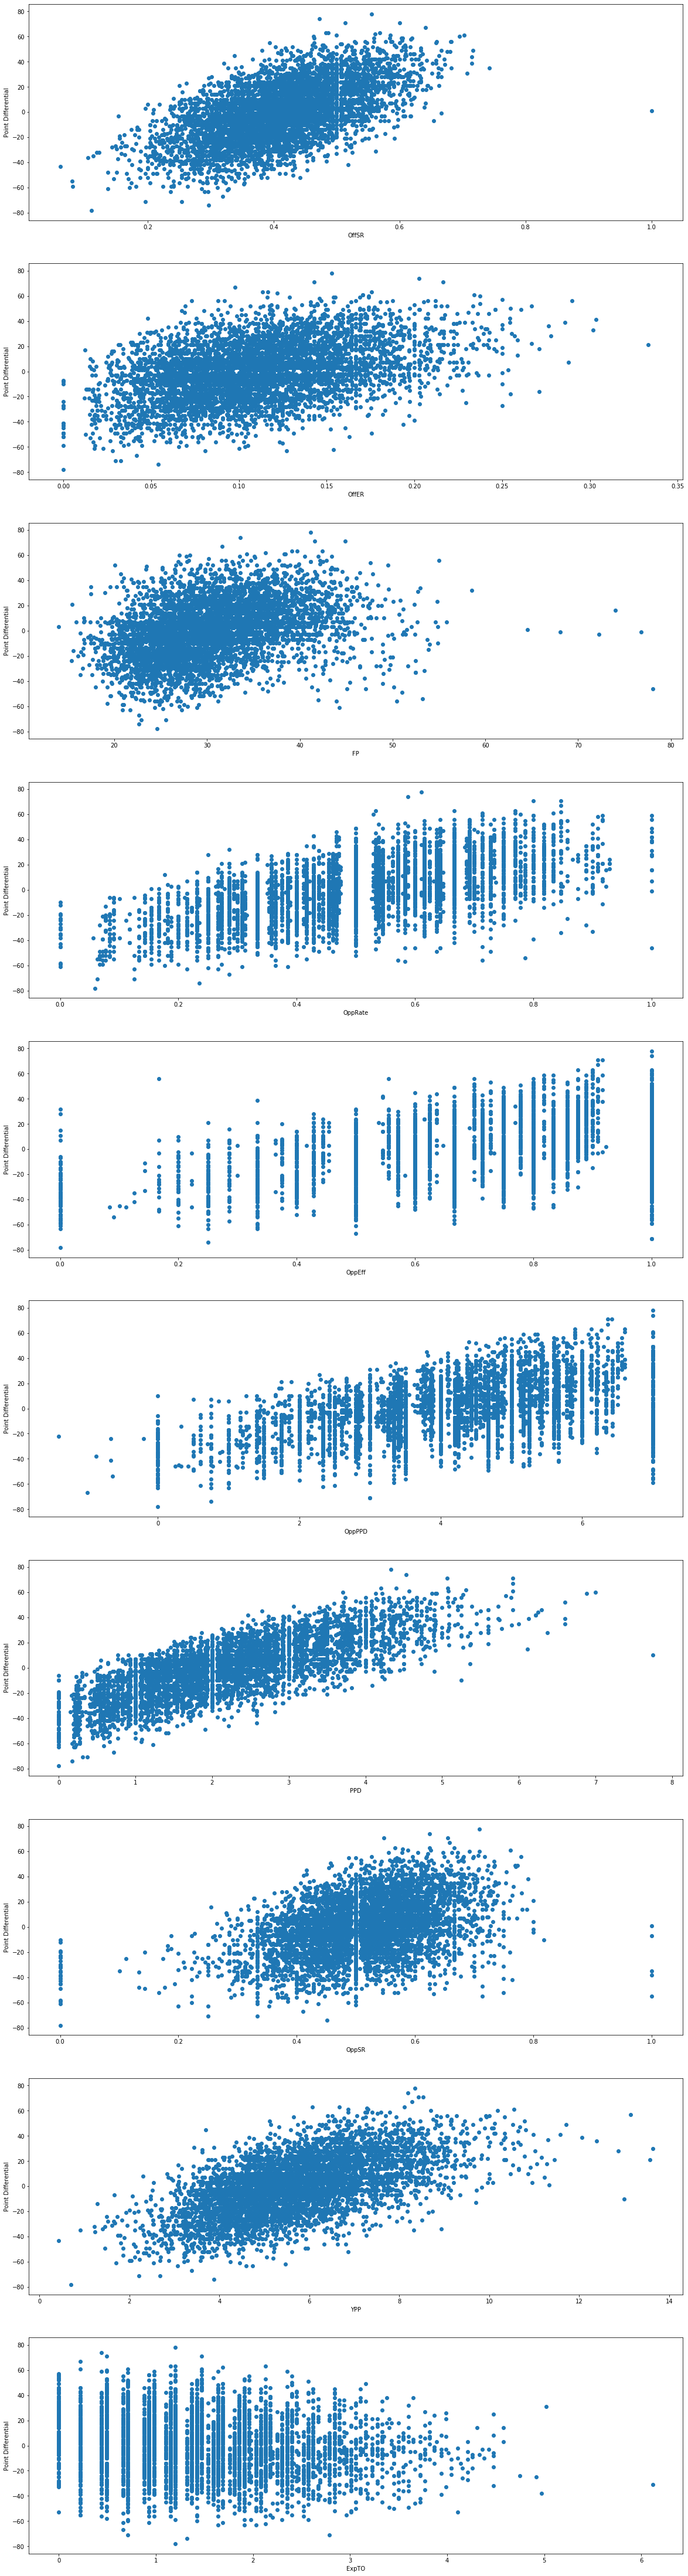

In [273]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

for i in range(len(inputs)):
    inpt = inputs[i]
    axes[i].scatter(stored_game_boxes[inpt], stored_game_boxes.PtsDiff);
    axes[i].set_xlabel(inpt)
    axes[i].set_ylabel("Point Differential");

In [274]:
# Eliminate outliers
from scipy import stats
import numpy as np
# stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
# stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
# stored_game_boxes.head()

In [275]:
# outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3.2)]
basis = stored_game_boxes #[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.2)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [276]:
# outliers

In [277]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,...,-14.846154,-0.352564,0.100000,1.400000,-1.339744,0.031318,-0.473659,0.22,-0.694763,-1.389526
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,...,-2.563636,0.218182,-0.250000,-2.750000,-0.336364,-0.222222,1.084765,0.22,0.020700,0.041401
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,...,2.563636,-0.218182,0.250000,2.750000,0.336364,0.222222,-1.084765,-0.22,-0.020700,-0.041401
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,...,-2.652381,-0.661905,0.090909,0.636364,-3.666667,-0.379661,-5.658696,-0.22,-1.498331,-2.996662
1,Louisville,2016,400869341,70.0,56.0,0.999941,0.681159,0.289855,9.275362,33.866667,...,2.652381,0.661905,-0.090909,-0.636364,3.666667,0.379661,5.658696,0.22,1.498331,2.996662


In [278]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression


inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [279]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = yfit.mean()
    std = yfit.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")

In [280]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {model.score(train_data["5FRDiff"][:,np.newaxis], train_data.PtsDiff)}\n')
# print(f'Linear Regression Model:\nPtsDiff = {model.intercept_:.5f}')
# for i in range(len(inputDiffs)):
#     inptDf = inputDiffs[i]
#     print(f"+ ({model.coef_[i]:.5f} * {inptDf})")
    
test.corr()

Linear Regression: y = 13.94604x + -0.01392
R-squared: 0.8618018916502103



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,PredPtsDiff
ActPtsDiff,1.000000,0.763837,0.551484,0.471021,0.796315,0.604930,0.700040,0.982398,0.511386,0.769833,-0.482869,0.926666
OffSRDiff,0.763837,1.000000,0.468974,0.261320,0.702912,0.382100,0.490791,0.764836,0.741926,0.703675,-0.312411,0.743090
OffERDiff,0.551484,0.468974,1.000000,0.140058,0.501275,0.294095,0.349939,0.545074,0.348827,0.791016,-0.206215,0.630843
FPDiff,0.471021,0.261320,0.140058,1.000000,0.591904,0.075359,0.099651,0.445065,0.003697,0.206994,-0.276655,0.651277
OppRateDiff,0.796315,0.702912,0.501275,0.591904,1.000000,0.208903,0.244961,0.798566,0.273767,0.659559,-0.311397,0.848984
OppEffDiff,0.604930,0.382100,0.294095,0.075359,0.208903,1.000000,0.853022,0.603988,0.486889,0.439392,-0.311344,0.484775
OppPPDDiff,0.700040,0.490791,0.349939,0.099651,0.244961,0.853022,1.000000,0.703597,0.622025,0.521939,-0.392359,0.566334
PPDDiff,0.982398,0.764836,0.545074,0.445065,0.798566,0.603988,0.703597,1.000000,0.510846,0.756106,-0.472567,0.916097
OppSRDiff,0.511386,0.741926,0.348827,0.003697,0.273767,0.486889,0.622025,0.510846,1.000000,0.526833,-0.259159,0.469234
YPPDiff,0.769833,0.703675,0.791016,0.206994,0.659559,0.439392,0.521939,0.756106,0.526833,1.000000,-0.336127,0.837988


In [281]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0

Proj MOV: Virginia Tech by -1.0 (exact value: -1.103002612601491)
Z score: -0.07744856624280164
Win Prob for Virginia Tech: 46.91%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,...,-5.4,-0.104762,0.208333,1.791667,-0.052381,0.118588,0.994779,-0.66,0.039046,0.078093
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,...,5.4,0.104762,-0.208333,-1.791667,0.052381,-0.118588,-0.994779,0.66,-0.039046,-0.078093


In [282]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0

Proj MOV: Georgia Tech by -12.0 (exact value: -12.394569539906344)
Z score: -0.6197494929871428
Win Prob for Georgia Tech: 26.77%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,17.444444,...,-21.305556,-0.305556,0.166667,1.166667,1.361111,0.07619,-0.330005,-0.66,-0.443877,-0.887754
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,38.750000,...,21.305556,0.305556,-0.166667,-1.166667,-1.361111,-0.07619,0.330005,0.66,0.443877,0.887754


In [283]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0

Proj MOV: Georgia Tech by 9.0 (exact value: 8.950662255254393)
Z score: 0.405399545991398
Win Prob for Georgia Tech: 65.74%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,23.700000,...,-5.936364,-0.036364,0.261905,0.5,0.054545,-0.01919,-1.322588,0.0,-0.321402,-0.642805
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,29.636364,...,5.936364,0.036364,-0.261905,-0.5,-0.054545,0.01919,1.322588,0.0,0.321402,0.642805


In [284]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Actual Winner: Mississippi State
MOV: Mississippi State by 1.0

Proj MOV: Mississippi State by 4.0 (exact value: 4.36638660328073)
Z score: 0.18523019743932548
Win Prob for Mississippi State: 57.35%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,25.545455,...,-5.787879,0.121212,-0.15,-1.05,0.068182,-0.059649,0.080622,0.22,-0.157045,-0.31409
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,31.333333,...,5.787879,-0.121212,0.15,1.05,-0.068182,0.059649,-0.080622,-0.22,0.157045,0.31409


In [285]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Actual Winner: Texas A&M
MOV: Texas A&M by 2.0

Proj MOV: Texas A&M by -6.0 (exact value: -5.616281812420722)
Z score: -0.2942081628935852
Win Prob for Texas A&M: 38.43%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,46.176471,...,1.018576,0.021672,-0.00641,0.166667,0.340557,0.014666,0.876496,0.0,0.200859,0.401717
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,45.157895,...,-1.018576,-0.021672,0.00641,-0.166667,-0.340557,-0.014666,-0.876496,0.0,-0.200859,-0.401717


In [286]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

team_wp_frame = pd.DataFrame()
for team in team_list:
    team_wp_frame = team_wp_frame.append(pd.DataFrame({
        'team':[team],
        'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
    }))
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * 12.0)
team_wp_frame['proj_losses'] = 12 - team_wp_frame['proj_wins']
team_wp_frame.sort_values(by=['avg_win_prob'], ascending=False)

,team,avg_win_prob,proj_wins,proj_losses
0,Ohio State,0.938358,11.0,1.0
0,Alabama,0.912641,11.0,1.0
0,Clemson,0.902811,11.0,1.0
0,LSU,0.858609,10.0,2.0
0,Utah,0.856301,10.0,2.0
0,Wisconsin,0.823113,10.0,2.0
0,Oklahoma,0.815307,10.0,2.0
0,Memphis,0.805386,10.0,2.0
0,Notre Dame,0.798364,10.0,2.0
0,Louisiana,0.796732,10.0,2.0


In [287]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].mean()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.15434664922287544, -20.686105661510805]

In [294]:
team_triples = [
    ['Utah','Oregon',6.5],
    ['Oklahoma','Baylor',8.5],
    ['Central Michigan','Miami (OH)',6.5],
    ['Appalachian State','Louisiana',6.5],
    ['Florida Atlantic','UAB',7.5],
    ['Memphis','Cincinnati',9.5],
    ['LSU','Georgia',7.5],
    ['Boise State','Hawai\'i',13.5],
    ['Clemson', 'Virginia',28.5],
    ['Ohio State','Wisconsin',16.5],
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "team": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,team,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ats_pick
0,Clemson,Virginia,28.5,8.367462,0.647058,False,Virginia
0,Boise State,Hawai'i,13.5,6.539913,0.613946,False,Hawai'i
0,Ohio State,Wisconsin,16.5,6.376669,0.610943,False,Wisconsin
0,Memphis,Cincinnati,9.5,4.522490,0.576414,False,Cincinnati
0,Oklahoma,Baylor,8.5,4.163088,0.569643,False,Baylor
0,Central Michigan,Miami (OH),6.5,3.081969,0.549162,False,Miami (OH)
0,LSU,Georgia,7.5,2.701039,0.541911,False,Georgia
0,Utah,Oregon,6.5,2.565613,0.539329,False,Oregon
0,Appalachian State,Louisiana,6.5,-1.092584,0.469332,False,Louisiana
0,Florida Atlantic,UAB,7.5,-1.233081,0.466649,False,UAB


In [289]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Could not find basic game data for game_id 401112521 locally, checking CFB Data API
Could not find drive data for game_id 401112521 locally, checking CFB Data API
Could not find play by play data for game_id 401112521 locally, checking CFB Data API
Actual Winner: Virginia
MOV: Virginia by 9

Proj MOV: Virginia by 15.0 (exact value: 14.6561576204968)
Z score: 0.679417797313495
Win Prob for Virginia: 75.16%
Could not find basic game data for game_id 401112521 locally, checking CFB Data API
Could not find drive data for game_id 401112521 locally, checking CFB Data API
Could not find play by play data for game_id 401112521 locally, checking CFB Data API


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30,-9,0.577256,0.394231,0.153846,5.788462,31.600000,...,4.907692,-0.071795,0.0,-0.571429,-1.0,0.109974,-3.692551,0.44,-0.525959,-1.051917
1,Virginia,2019,401112521,39,9,0.422744,0.367089,0.240506,9.481013,26.692308,...,-4.907692,0.071795,0.0,0.571429,1.0,-0.109974,3.692551,-0.44,0.525959,1.051917


In [290]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Actual Winner: North Carolina
MOV: North Carolina by 16.0

Proj MOV: North Carolina by 6.0 (exact value: 5.602221068784369)
Z score: 0.24458371146088986
Win Prob for North Carolina: 59.66%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,29.153846,...,2.230769,0.230769,0.107143,0.178571,1.230769,-0.123887,-0.349659,0.0,0.201353,0.402705
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,26.923077,...,-2.230769,-0.230769,-0.107143,-0.178571,-1.230769,0.123887,0.349659,0.0,-0.201353,-0.402705


In [291]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0

Proj MOV: Pittsburgh by 13.0 (exact value: 12.768047591531714)
Z score: 0.5887373961703166
Win Prob for Pittsburgh: 72.20%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,35.285714,...,3.516484,0.120879,0.166667,0.833333,0.659341,0.20743,1.49512,0.0,0.458265,0.91653
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,31.769231,...,-3.516484,-0.120879,-0.166667,-0.833333,-0.659341,-0.20743,-1.49512,0.0,-0.458265,-0.91653


In [292]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Could not find basic game data for game_id 401110865 locally, checking CFB Data API
Could not find drive data for game_id 401110865 locally, checking CFB Data API
Could not find play by play data for game_id 401110865 locally, checking CFB Data API
Actual Winner: Auburn
MOV: Auburn by 3

Proj MOV: Auburn by 6.0 (exact value: 6.015557389578814)
Z score: 0.2644350457590452
Win Prob for Auburn: 60.43%
Could not find basic game data for game_id 401110865 locally, checking CFB Data API
Could not find drive data for game_id 401110865 locally, checking CFB Data API
Could not find play by play data for game_id 401110865 locally, checking CFB Data API


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,5FR,5FRDiff
0,Alabama,2019,401110865,45,-3,0.400109,0.435185,0.175926,7.518519,31.153846,...,-2.262821,0.108974,-0.111111,-0.063492,-0.538462,0.044834,-0.568438,0.44,-0.216172,-0.432343
1,Auburn,2019,401110865,48,3,0.599891,0.391304,0.173913,8.086957,33.416667,...,2.262821,-0.108974,0.111111,0.063492,0.538462,-0.044834,0.568438,-0.44,0.216172,0.432343
